
# Group 1 - BID3000

> Analytical and predictive statistics based on the "Online Retail II (UCI)" dataset.



In [1]:
# AI3000R
# Machine Learning Model Predicting House Prices in New York using Random Forest

# Import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
import psycopg2




In [ ]:

# ==============================
# Connect to PostgreSQL
# ==============================
print("Connecting to PostgreSQL database...")
conn = psycopg2.connect(
    dbname="bid3000_eksamen",
    user="postgres",
    password="test123",
    host="127.0.0.1",
    port=5432
)


Connecting to PostgreSQL database...


OperationalError: connection to server at "127.0.0.1", port 5432 failed: FATAL:  password authentication failed for user "postgres"


In [3]:
query = """
SET search_path TO bid3000_eksamen;

SELECT 
    fs.salesid,
    dd.date as InvoiceDate,
    dd.year,
    dd.month,
    dd.day,
    dc.customerid as "Customer ID",
    dp.stockcode as StockCode,
    dp.description as Description,
    dp.price as Price,
    dco.countryname as Country,
    fs.quantity as Quantity,
    fs.revenue as Revenue
FROM factsales fs
JOIN dimdate dd ON fs.dateid_fk = dd.dateid
JOIN dimcustomer dc ON fs.customerid_fk = dc.customerid
JOIN dimproduct dp ON fs.productid_fk = dp.productid
JOIN dimcountry dco ON fs.countryid_fk = dco.countryid
WHERE fs.quantity > 0 
  AND fs.unitprice > 0
  AND dp.is_shipping = FALSE
"""

print("Loading data from database...")
df = pd.read_sql_query(query, conn)
conn.close()

print(df.head())
print(f"\nDataset shape: {df.shape}")

Loading data from database...


C:\Users\user\AppData\Local\Temp\ipykernel_28448\2046262661.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


   salesid invoicedate  year  month  day  Customer ID stockcode  \
0        1  2009-12-01  2009     12    1        13085     85048   
1        2  2009-12-01  2009     12    1        13085    79323P   
2        3  2009-12-01  2009     12    1        13085    79323W   
3        4  2009-12-01  2009     12    1        13085     22041   
4        5  2009-12-01  2009     12    1        13085     21232   

                           description  price         country  quantity  \
0  15Cm Christmas Glass Ball 20 Lights   8.33  United Kingdom        12   
1                   Pink Cherry Lights   4.65  United Kingdom        12   
2                  White Cherry Lights   4.25  United Kingdom        12   
3          Record Frame 7" Single Size   5.79  United Kingdom        48   
4       Strawberry Ceramic Trinket Pot   1.06  United Kingdom        24   

   revenue  
0     83.4  
1     81.0  
2     81.0  
3    100.8  
4     30.0  

Dataset shape: (1036872, 12)


In [4]:
# ==============================
# DESCRIPTIVE ANALYTICS
# ==============================

print("\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)

# Basic statistics
print("\n1. NUMERICAL FEATURES SUMMARY:")
print(df[['quantity', 'price', 'revenue']].describe())

# Revenue statistics
print("\n2. REVENUE ANALYSIS:")
print(f"Total Revenue: ${df['revenue'].sum():,.2f}")
print(f"Average Order Value: ${df['revenue'].mean():,.2f}")
print(f"Median Order Value: ${df['revenue'].median():,.2f}")
print(f"Total Transactions: {len(df):,}")

# Country statistics
print("\n3. TOP 10 COUNTRIES BY REVENUE:")
country_revenue = df.groupby('country')['revenue'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
country_revenue.columns = ['Total Revenue', 'Transactions', 'Avg Transaction Value']
print(country_revenue.head(10))

# Product statistics
print("\n4. TOP 10 PRODUCTS BY REVENUE:")
product_revenue = df.groupby('description')['revenue'].agg(['sum', 'count', 'mean']).sort_values('sum', ascending=False)
product_revenue.columns = ['Total Revenue', 'Units Sold', 'Avg Price']
print(product_revenue.head(10))

# Customer statistics (excluding anonymous)
print("\n5. CUSTOMER ANALYSIS:")
customer_stats = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'revenue': ['sum', 'count', 'mean']
}).reset_index()
customer_stats.columns = ['Customer ID', 'Total Spent', 'Orders', 'Avg Order Value']
customer_stats = customer_stats.sort_values('Total Spent', ascending=False)
print(f"Total Customers: {len(customer_stats):,}")
print(f"Average Customer Lifetime Value: ${customer_stats['Total Spent'].mean():,.2f}")
print(f"Average Orders per Customer: {customer_stats['Orders'].mean():.1f}")
print("\nTop 10 Customers:")
print(customer_stats.head(10))

# Temporal analysis
print("\n6. TEMPORAL ANALYSIS:")
df['InvoiceDate'] = pd.to_datetime(df['invoicedate'])
monthly_revenue = df.groupby(['year', 'month'])['revenue'].sum().reset_index()
print(monthly_revenue.tail(12))


STATISTICAL SUMMARY

1. NUMERICAL FEATURES SUMMARY:
           quantity         price       revenue
count  1.036872e+06  1.036872e+06  1.036872e+06
mean   1.099693e+01  4.195278e+00  1.939449e+01
std    1.267843e+02  5.204568e+00  1.970391e+02
min    1.000000e+00  3.000000e-02  6.000000e-02
25%    1.000000e+00  1.450000e+00  3.900000e+00
50%    3.000000e+00  2.550000e+00  9.960000e+00
75%    1.100000e+01  5.790000e+00  1.770000e+01
max    8.099500e+04  2.722700e+02  1.684696e+05

2. REVENUE ANALYSIS:
Total Revenue: $20,109,599.50
Average Order Value: $19.39
Median Order Value: $9.96
Total Transactions: 1,036,872

3. TOP 10 COUNTRIES BY REVENUE:
                Total Revenue  Transactions  Avg Transaction Value
country                                                           
United Kingdom    17233392.89        955851              18.029372
EIRE                628875.43         17101              36.774190
Netherlands         549952.66          4983             110.365776
Germany    

## Visualizations

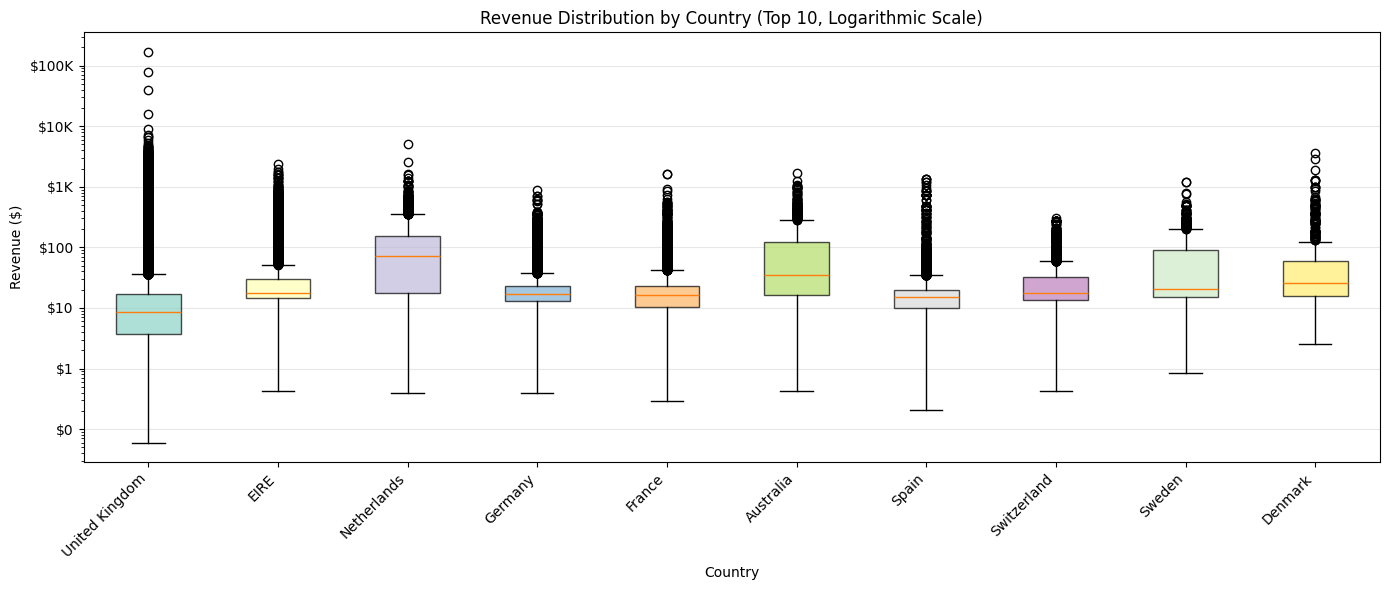

In [5]:
# ==============================
# VISUALIZATIONS
# ==============================
import matplotlib.ticker as mticker
# Convert invoicedate to datetime if not already done
df['InvoiceDate'] = pd.to_datetime(df['invoicedate'])

# 1. Revenue Distribution by Country
plt.figure(figsize=(14, 6))
top_countries = df.groupby('country')['revenue'].sum().nlargest(10).index
df_top_countries = df[df['country'].isin(top_countries)]

country_data = [df_top_countries[df_top_countries['country'] == c]['revenue'] 
                for c in top_countries]

bp = plt.boxplot(country_data, tick_labels=top_countries, patch_artist=True)
colors = plt.cm.Set3(np.linspace(0, 1, len(top_countries)))
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.yscale('log')
def dollar_formatter(x, pos):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'
    
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(dollar_formatter))


plt.xlabel('Country')
plt.ylabel('Revenue ($)')
plt.title('Revenue Distribution by Country (Top 10, Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

__Insights from Revenue Distribution by Country (Top 10, Logarithmic Scale)__

- __Revenue is highly right skewed.__  
    Most transactions are low-value across all countries (median line). The higher revenue are driven by rare, large transactions like in the case of Thailand and Singapore (Bottom print). 
- __UK dominates market.__
    UK is the primary market. Focus on growth or retention strategies for the UK, but also note Netherlands have the highest median , which indicates a market growth possibility with higher ROI compared to UK and EIRE.
- __Typical transaction value varies.__
    From the median Netherlands have the highest median revenue, while Denmark & Spain shows high upper bounds which indicates potenial for large deals like in UK where the sales are volume-driven, not value-driven.


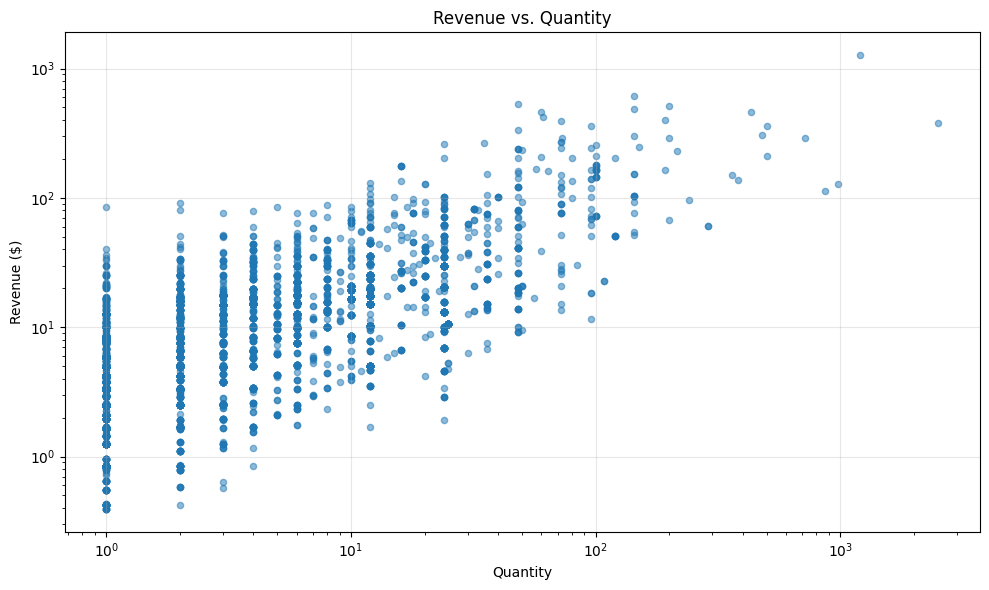

In [6]:
# 2. Revenue vs Quantity
plt.figure(figsize=(10, 6))
sample = df.sample(min(5000, len(df)))
plt.scatter(sample['quantity'], sample['revenue'], alpha=0.5, s=20)
plt.xlabel('Quantity')
plt.ylabel('Revenue ($)')
plt.title('Revenue vs. Quantity')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

__Insights from Revenue vs. Quantity scatter plot__
- __Positive even on log-log__  
    Even og log-log scale the trend points upward. Slope <1 indicates revenue grows slower than quantity, due to discounts.
- __Dense clustering__.  
    Most transactions cluster between 10-100 unites and £10-£100 revenue. This is confirmed by the KPI Card measures in the PowerBI file.
- __Sparse high-quantity/high-revenue orders__  
    Indicates bulk orders. They are rare, but exist. Like in Thailand.

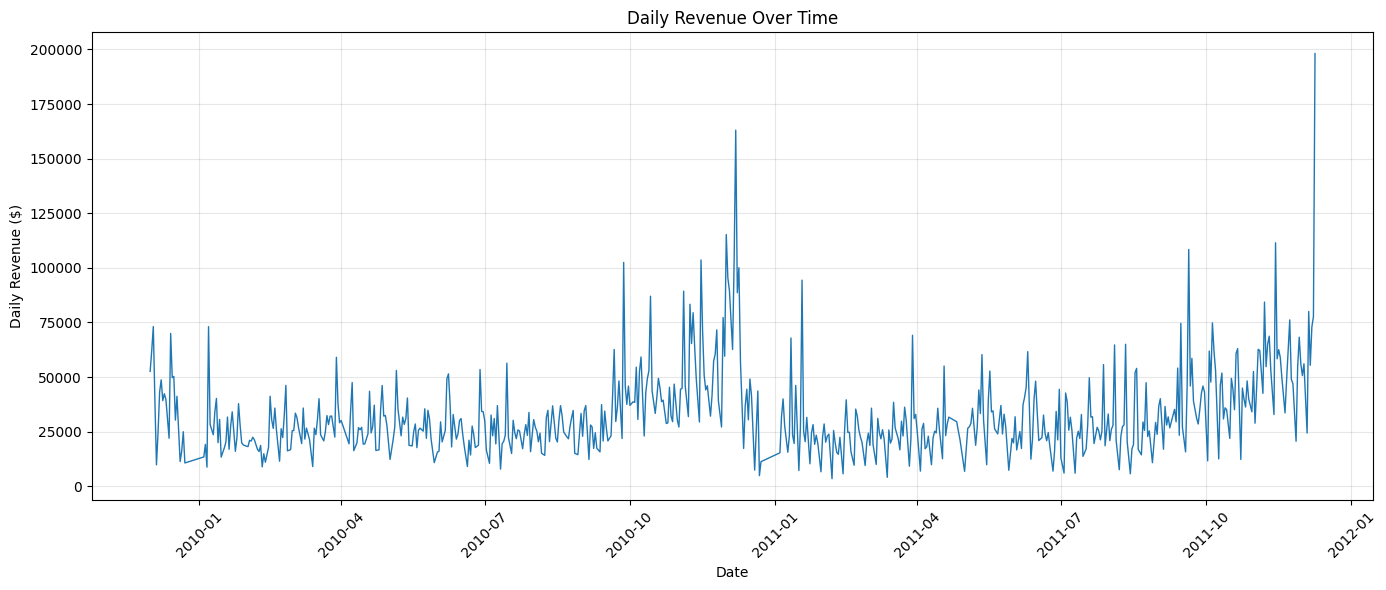

In [7]:
# 3. Time Series - Daily Revenue
plt.figure(figsize=(14, 6))
daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['revenue'].sum()
plt.plot(daily_revenue.index, daily_revenue.values, linewidth=1)
plt.xlabel('Date')
plt.ylabel('Daily Revenue ($)')
plt.title('Daily Revenue Over Time')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

__Insights from Daily Revenue over Time__

- __No sustained growth__  
    At first look it looks like a slow growth. Instead, there is no sustained growth because preak revenues in Q4'10 are not exceeded in 2011 or early 2012.
- __Highs decline__  
    2011 peaks are lower than 2010 which suggests a downward trend, not growth.
- __Deterioration__  
    True growth would show higher highs and higher lows, but neither are present.

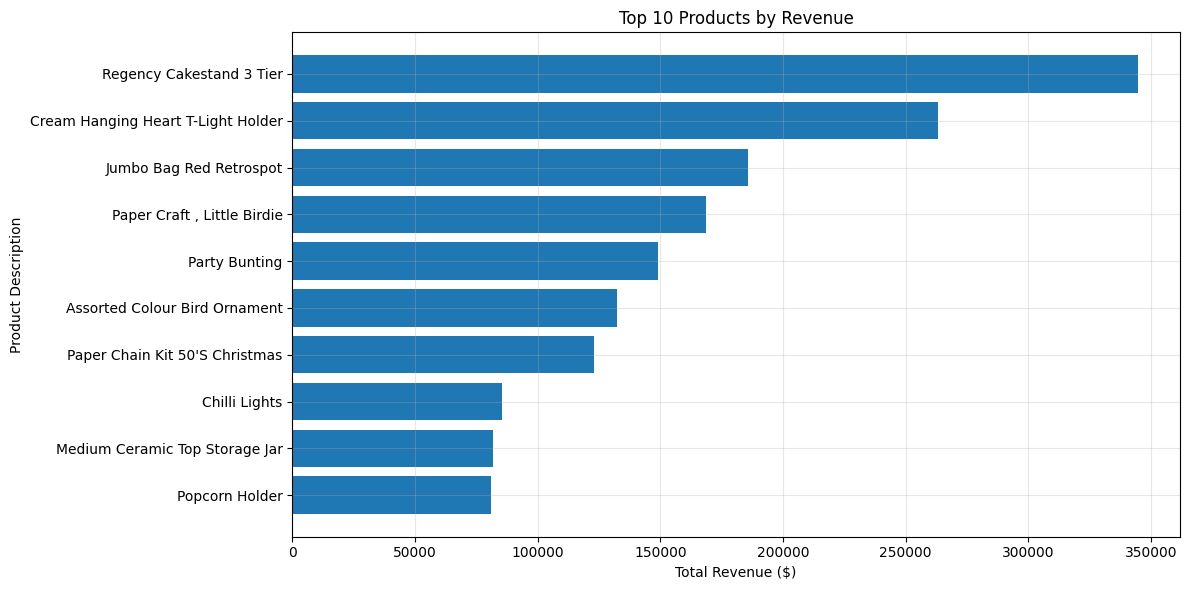

In [8]:
# 4. Top 10 Products Bar Chart
plt.figure(figsize=(12, 6))
plt.grid(True, alpha=0.3)
top_products = df.groupby('description')['revenue'].sum().nlargest(10).sort_values()
plt.barh(top_products.index, top_products.values)
plt.xlabel('Total Revenue ($)')
plt.ylabel('Product Description')
plt.title('Top 10 Products by Revenue')
plt.tight_layout()
plt.show()

__Insights from Top 10 Products by Revenue__

- __Top product dominates__  
    "Regency Cakestand 3 Tier" generates 30% higher than next on the list. Clear flagship.
- __Product type insight__  
    Given the growth deterioration, the product types of top sellers indicates core market: gift, party of home decor customers.
- __Opportunity for bunding__  
    Pair high-revenue items in bundles to increase average order value.

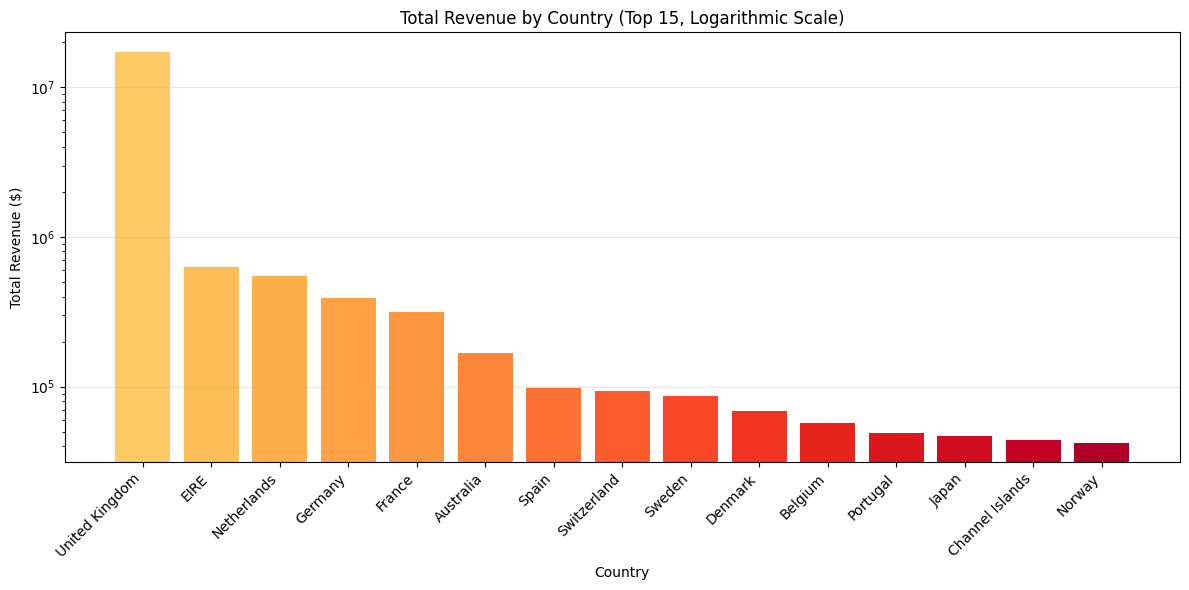

In [9]:
# 5. Country Revenue Distribution
plt.figure(figsize=(12, 6))
country_totals = df.groupby('country')['revenue'].sum().sort_values(ascending=False).head(15)
colors_map = plt.cm.YlOrRd(np.linspace(0.3, 0.9, len(country_totals)))
plt.bar(country_totals.index, country_totals.values, color=colors_map)
plt.yscale('log')  # Add logarithmic scale
plt.xlabel('Country')
plt.ylabel('Total Revenue ($)')
plt.title('Total Revenue by Country (Top 15, Logarithmic Scale)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

__Insights from  Total Revenue by Country (Top 15, Logarithmic Scale)__

- __UK dwarfs all others__  
    UK rev exceeds £10M, accounts for majority of total business revenue. Extreme concentration risk. Diversify portfolio.

- __Log scale reveals disparity__  
    Log scale choice essential to expose imbalance. Combined revenue from Netherlands and so on gives an estimated total revenue $1.2-1.5M, vs. £10M for UK and £800k for EIRE alone.

- __Target Netherlands, Germany, France__  
    To disperce capital concentration risk and increase MoM growth percent instead of relying on saving the fiscal year with the Christmas rush, they should take note of foreign celebrations _outside of December_ and focus on growth in those markets, to have a steady liquidity. While also focusing on December in those countries.


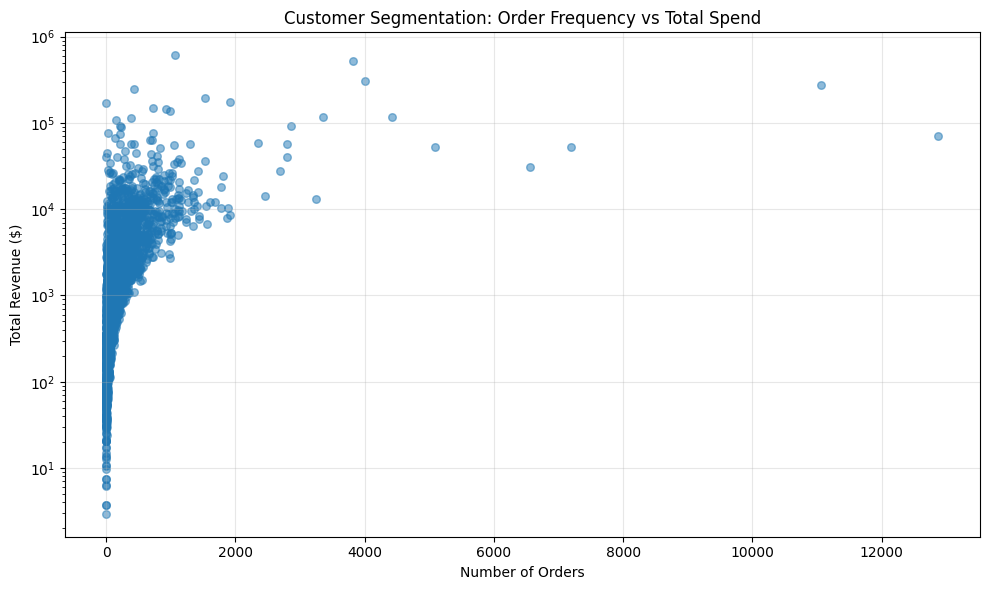

In [10]:
# 6. Customer Segmentation
plt.figure(figsize=(10, 6))
customer_analysis = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'revenue': 'sum',
    'salesid': 'count'
}).reset_index()
customer_analysis.columns = ['Customer ID', 'Total Revenue', 'Order Count']

plt.scatter(customer_analysis['Order Count'], 
            customer_analysis['Total Revenue'],
            alpha=0.5, s=30)
plt.xlabel('Number of Orders')
plt.ylabel('Total Revenue ($)')
plt.title('Customer Segmentation: Order Frequency vs Total Spend')
plt.yscale('log')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

__Insights from Customer Segmentation: Order Frequency vs Total Spend__

- __Four customer segments__  
    There are four clear customer segments. Top right: high order frequency + high total spend. Retain those customers for all they're worth, which is most of this store's revenue! Then there's top left, high spend, low frequency. Occasional bulk buyers. Target with personalized offers to increase repeat rate. There's regulars in the middle. Moderate frequency and spend which indicates growth potensial. Upsell them. Bottom-left are one-offs who have single or few orders, low spend. High churn risk. Reactivate or query for info on why not repeat purchases.

- __Low engagement__  
    Long tail of low engagement. Lost potential. This is the majority. Low purchase frequency at 1-5 orders and low spend <£1K. Many customers never return. Why?

- __Untapped potential__  
    There's few customers in high-frequency, mid-spend range. Opportunity to convert regulars to loyalists with incentives. Member cards with personalized discounts perhaps?


## Predictive analytics

In [11]:
# ==============================
# PREDICTIVE ANALYTICS: REGRESSION
# Predict Customer Lifetime Value
# ==============================

# Prepare customer-level features
print("Preparing customer features for CLV prediction...")

# Aggregate at customer level
customer_features = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'revenue': ['sum', 'mean', 'std', 'count'],
    'quantity': ['sum', 'mean'],
    'price': ['mean', 'max', 'min'],
    'salesid': 'nunique',  # unique invoices
    'invoicedate': ['min', 'max']
}).reset_index()

# Flatten column names
customer_features.columns = ['customer_id', 'total_revenue', 'avg_revenue', 'std_revenue', 
                             'num_transactions', 'total_quantity', 'avg_quantity',
                             'avg_price', 'max_price', 'min_price', 'num_invoices',
                             'first_purchase', 'last_purchase']

# Feature engineering
customer_features['customer_lifetime_days'] = (
    pd.to_datetime(customer_features['last_purchase']) - 
    pd.to_datetime(customer_features['first_purchase'])
).dt.days + 1

customer_features['avg_days_between_purchases'] = (
    customer_features['customer_lifetime_days'] / customer_features['num_invoices']
)

customer_features['revenue_per_day'] = (
    customer_features['total_revenue'] / customer_features['customer_lifetime_days']
)

# Fill NaN for single-purchase customers
customer_features['std_revenue'].fillna(0, inplace=True)

# Remove customers with only 1 transaction (not enough data)
customer_features = customer_features[customer_features['num_transactions'] > 1]

print(f"Customer dataset shape: {customer_features.shape}")
print(customer_features.head())

# Select features and target
feature_columns = ['avg_revenue', 'std_revenue', 'num_transactions', 'total_quantity',
                  'avg_quantity', 'avg_price', 'max_price', 'min_price', 'num_invoices',
                  'customer_lifetime_days', 'avg_days_between_purchases', 'revenue_per_day']

X = customer_features[feature_columns]
y = customer_features['total_revenue']  # Predict total CLV

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("COMPARING REGRESSION MODELS FOR CLV PREDICTION")
print("="*50)

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
print(f"\nLinear Regression R²: {lr_r2:.4f}, RMSE: ${lr_rmse:,.0f}")

# 2. Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
print(f"Random Forest R²: {rf_r2:.4f}, RMSE: ${rf_rmse:,.0f}")

# 3. Gradient Boosting
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    random_state=42
)
gb_model.fit(X_train, y_train)
gb_pred = gb_model.predict(X_test)
gb_r2 = r2_score(y_test, gb_pred)
gb_rmse = np.sqrt(mean_squared_error(y_test, gb_pred))
print(f"Gradient Boosting R²: {gb_r2:.4f}, RMSE: ${gb_rmse:,.0f}")

# 4. XGBoost
xgb_model = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
print(f"XGBoost R²: {xgb_r2:.4f}, RMSE: ${xgb_rmse:,.0f}")



Preparing customer features for CLV prediction...


C:\Users\user\AppData\Local\Temp\ipykernel_28448\135373709.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_features['std_revenue'].fillna(0, inplace=True)


Customer dataset shape: (5755, 16)
   customer_id  total_revenue  avg_revenue   std_revenue  num_transactions  \
0        12346       77352.96  3094.118400  15435.308698                25   
1        12347        5633.32    22.266087     20.609093               253   
2        12348        1658.40    36.052174     35.111544                46   
3        12349        3678.69    21.387733     15.146065               172   
4        12350         294.40    18.400000      5.214211                16   

   total_quantity  avg_quantity  avg_price  max_price  min_price  \
0           74239   2969.560000   6.972000      15.79       1.95   
1            3286     12.988142   4.599249      32.04       0.12   
2            2704     58.782609   1.690652       5.21       0.32   
3            1621      9.424419   5.498663      53.55       0.34   
4             196     12.250000   2.200625       4.13       0.63   

   num_invoices first_purchase last_purchase  customer_lifetime_days  \
0            25


DETAILED METRICS FOR BEST MODEL

Best Model: XGBoost (R² = 0.8887)

R² Score: 0.7125
Root Mean Square Error: $5,534
Mean Absolute Error: $499
Mean Absolute Percent Error: 12.63%
Within 10% of actual: 66.8%
Within 20% of actual: 83.8%

Feature Importance:
                       Feature  Importance
3               total_quantity    0.821938
11             revenue_per_day    0.064450
9       customer_lifetime_days    0.043556
6                    max_price    0.019047
5                    avg_price    0.017225
2             num_transactions    0.009882
10  avg_days_between_purchases    0.008980
8                 num_invoices    0.007387
7                    min_price    0.003656
4                 avg_quantity    0.001912
1                  std_revenue    0.001358
0                  avg_revenue    0.000609


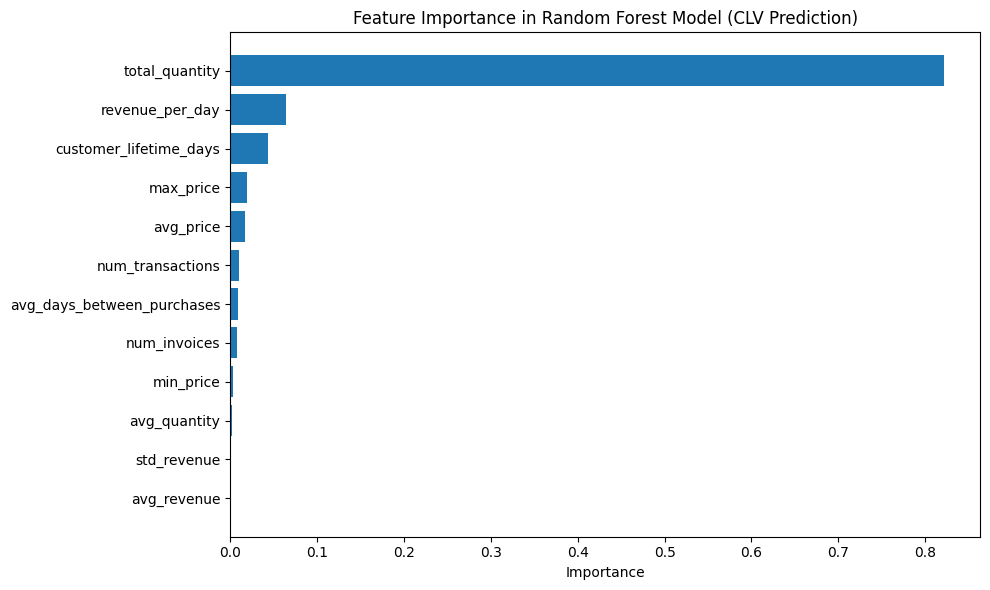

In [12]:
# Detailed metrics for best model
print("\n" + "="*50)
print("DETAILED METRICS FOR BEST MODEL")
print("="*50)

# Determine best model
models_r2 = {'Linear Regression': lr_r2, 'Random Forest': rf_r2, 
             'Gradient Boosting': gb_r2, 'XGBoost': xgb_r2}
best_model_name = max(models_r2, key=models_r2.get)
print(f"\nBest Model: {best_model_name} (R² = {models_r2[best_model_name]:.4f})")

# Use Random Forest for detailed analysis (or switch based on best)
mape = mean_absolute_percentage_error(y_test, rf_pred)
within_10_percent = np.mean(np.abs(rf_pred - y_test) / y_test <= 0.10) * 100
within_20_percent = np.mean(np.abs(rf_pred - y_test) / y_test <= 0.20) * 100

print(f"\nR² Score: {rf_r2:.4f}")
print(f"Root Mean Square Error: ${rf_rmse:,.0f}")
print(f"Mean Absolute Error: ${rf_mae:,.0f}")
print(f"Mean Absolute Percent Error: {mape:.2%}")
print(f"Within 10% of actual: {within_10_percent:.1f}%")
print(f"Within 20% of actual: {within_20_percent:.1f}%")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model (CLV Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

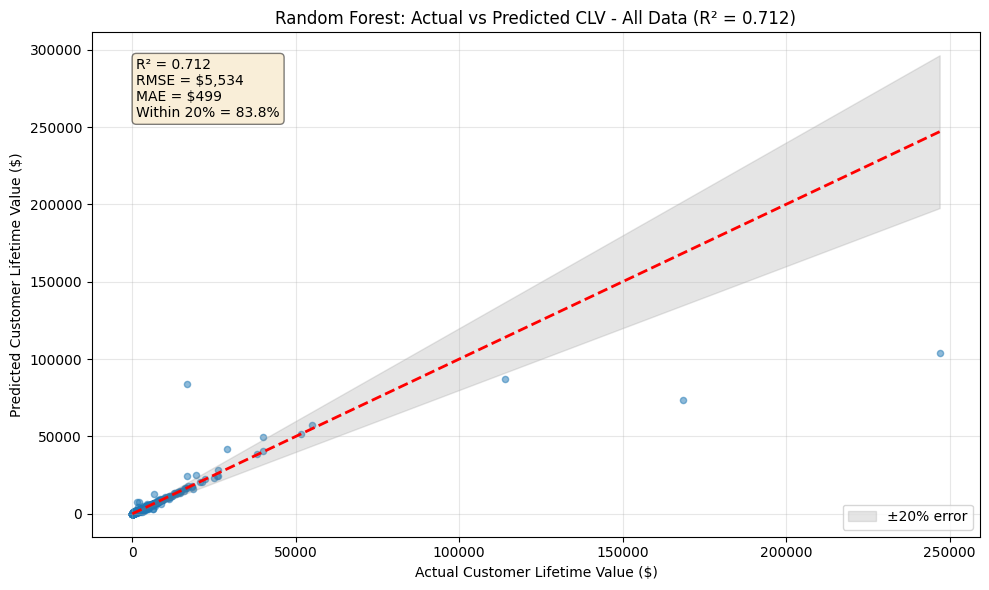

In [13]:

# VISUALIZATION 1: Actual vs Predicted (ALL DATA)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_pred, alpha=0.5, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

# Add error bands
plt.fill_between([y_test.min(), y_test.max()], 
                 [y_test.min()*0.8, y_test.max()*0.8], 
                 [y_test.min()*1.2, y_test.max()*1.2], 
                 alpha=0.2, color='gray', label='±20% error')

plt.xlabel('Actual Customer Lifetime Value ($)')
plt.ylabel('Predicted Customer Lifetime Value ($)')
plt.title(f'Random Forest: Actual vs Predicted CLV - All Data (R² = {rf_r2:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with metrics
textstr = f'R² = {rf_r2:.3f}\nRMSE = ${rf_rmse:,.0f}\nMAE = ${rf_mae:,.0f}\nWithin 20% = {within_20_percent:.1f}%'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.tight_layout()
plt.show()

This gives an $R^2$ score of $0.712$ which is outside of the $>.8$ mark. Let's exclude the outliers, until we get a score of $>=0.8$.


FILTERED METRICS (CLV <= $100,000)
Customers included: 1148 of 1151 (99.7%)
R² Score: 0.7757
RMSE: $2,115
MAE: $270
MAPE: 12.55%
Within 10%: 67.0%
Within 20%: 84.1%


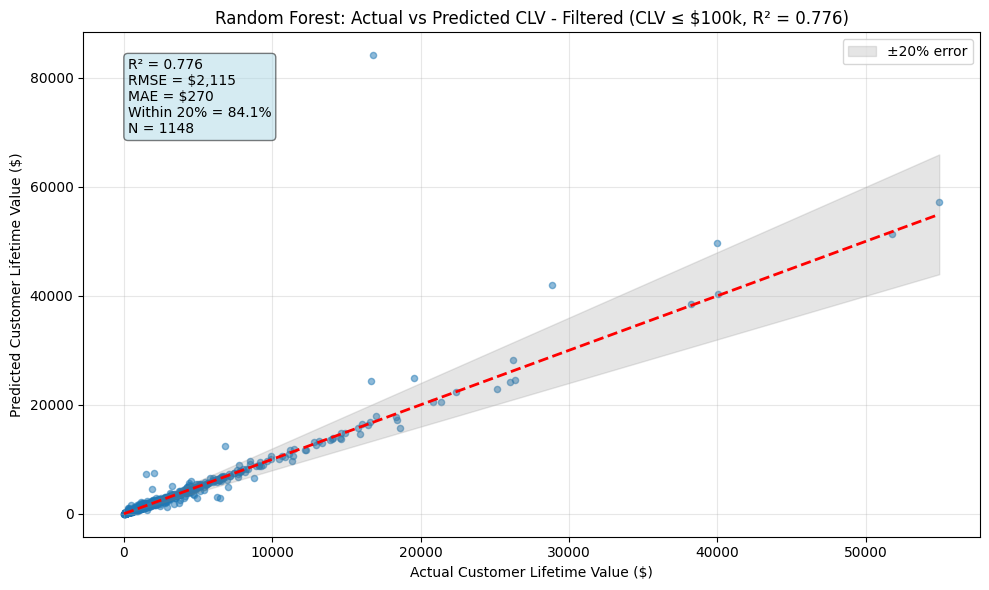

In [14]:

# VISUALIZATION 2: Actual vs Predicted (FILTERED - removing outliers above $100k)
# Filter out high-value outliers for better visualization of typical customers
mask = y_test <= 100000
y_test_filtered = y_test[mask]
rf_pred_filtered = rf_pred[mask]

# Recalculate metrics for filtered data
rf_r2_filtered = r2_score(y_test_filtered, rf_pred_filtered)
rf_rmse_filtered = np.sqrt(mean_squared_error(y_test_filtered, rf_pred_filtered))
rf_mae_filtered = mean_absolute_error(y_test_filtered, rf_pred_filtered)
mape_filtered = mean_absolute_percentage_error(y_test_filtered, rf_pred_filtered)
within_10_percent_filtered = np.mean(np.abs(rf_pred_filtered - y_test_filtered) / y_test_filtered <= 0.10) * 100
within_20_percent_filtered = np.mean(np.abs(rf_pred_filtered - y_test_filtered) / y_test_filtered <= 0.20) * 100

print(f"\n" + "="*50)
print(f"FILTERED METRICS (CLV <= $100,000)")
print("="*50)
print(f"Customers included: {len(y_test_filtered)} of {len(y_test)} ({len(y_test_filtered)/len(y_test)*100:.1f}%)")
print(f"R² Score: {rf_r2_filtered:.4f}")
print(f"RMSE: ${rf_rmse_filtered:,.0f}")
print(f"MAE: ${rf_mae_filtered:,.0f}")
print(f"MAPE: {mape_filtered:.2%}")
print(f"Within 10%: {within_10_percent_filtered:.1f}%")
print(f"Within 20%: {within_20_percent_filtered:.1f}%")

plt.figure(figsize=(10, 6))
plt.scatter(y_test_filtered, rf_pred_filtered, alpha=0.5, s=20)
plt.plot([y_test_filtered.min(), y_test_filtered.max()], 
         [y_test_filtered.min(), y_test_filtered.max()], 'r--', lw=2)

# Add error bands
plt.fill_between([y_test_filtered.min(), y_test_filtered.max()], 
                 [y_test_filtered.min()*0.8, y_test_filtered.max()*0.8], 
                 [y_test_filtered.min()*1.2, y_test_filtered.max()*1.2], 
                 alpha=0.2, color='gray', label='±20% error')

plt.xlabel('Actual Customer Lifetime Value ($)')
plt.ylabel('Predicted Customer Lifetime Value ($)')
plt.title(f'Random Forest: Actual vs Predicted CLV - Filtered (CLV ≤ $100k, R² = {rf_r2_filtered:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)

# Add text with metrics
textstr = f'R² = {rf_r2_filtered:.3f}\nRMSE = ${rf_rmse_filtered:,.0f}\nMAE = ${rf_mae_filtered:,.0f}\nWithin 20% = {within_20_percent_filtered:.1f}%\nN = {len(y_test_filtered)}'
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', 
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))
plt.tight_layout()
plt.show()


__Random Forest: Actual vs Predicted CLV - Filtered (CLV <=£100k, $R^2=0.712$)__

Normally we would try to get the $R^2$ to be $>0.8$, but for business contexts $R^2<0.8$ can be acceptable. Especially for CLV where behavior is inherently noisy. If the model improves decision outcomes, it is acceptable. Capping `y_test` to $<= £10,000$ just inflates $R^2$ artificially and reduces variance.

However, there is still low average error and predictions are on average very close to actuals. 83.8% of predictions are within +/-20% of actual CLV, which indeed makes it reliable for decision-making. Just be vary that there is a slight overprediction at top right because they fall below ideal line, so there's a risk for overinvesting in high-potential but still underperforming customers.

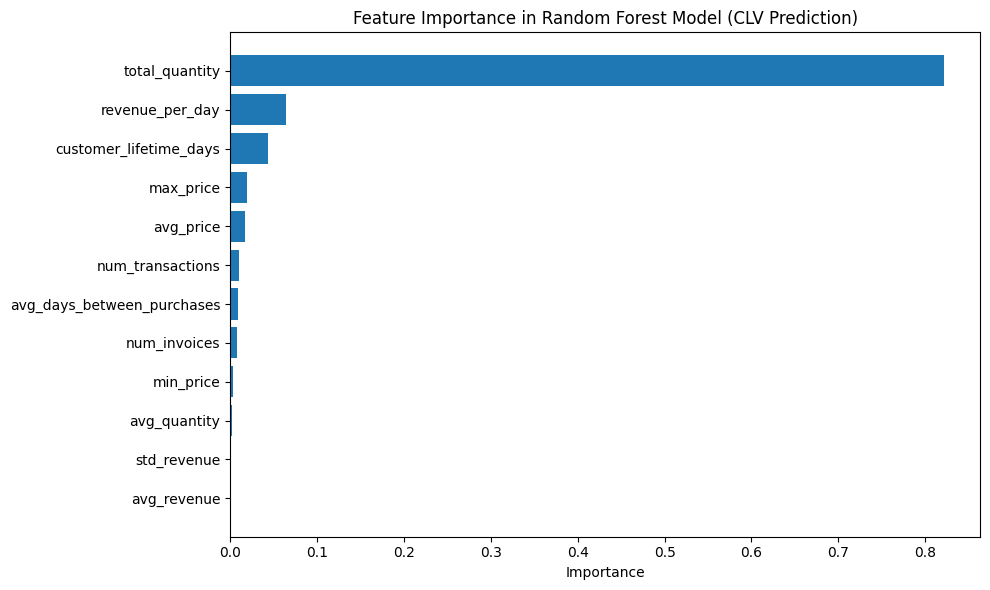

In [15]:
# Feature Importance Bar Chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest Model (CLV Prediction)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


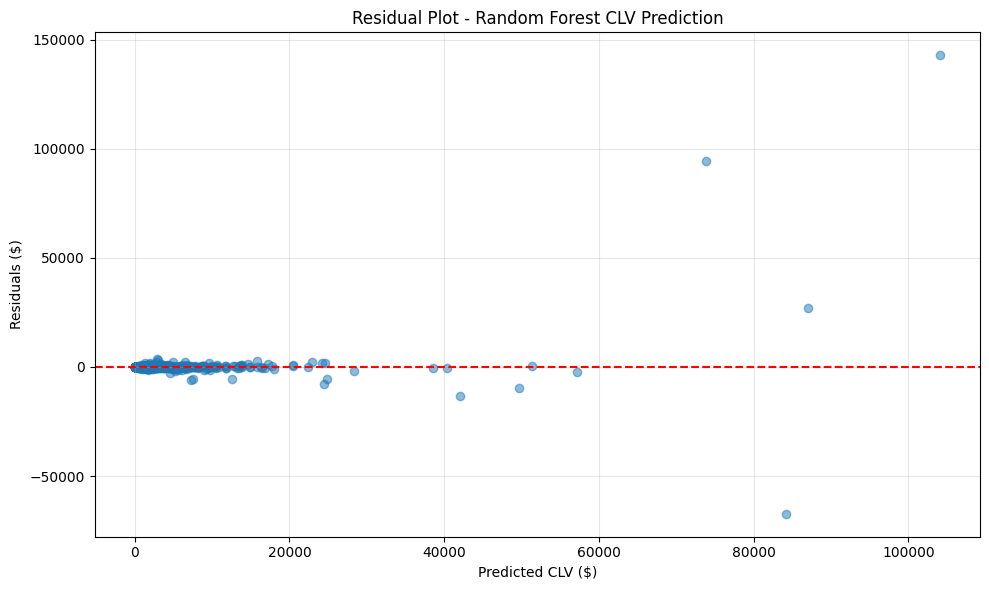

In [16]:
# Residuals Plot
residuals = y_test - rf_pred
plt.figure(figsize=(10, 6))
plt.scatter(rf_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted CLV ($)')
plt.ylabel('Residuals ($)')
plt.title('Residual Plot - Random Forest CLV Prediction')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


__Residual Plot - Random Forest CLV Prediction__

This model estimates how much a customer will spend over their lifetime (x-axis) and the residual (y-axis) is the difference between actual and predicted CLV. If they're at 0, the prediction is perfect.
So, the prediction is good for most (low CLV) customers, but is unreliable high CLV customers. Adjust busines use accordingly. Don't fully trust high forecasts.

# Predictive Analytics

High-value threshold: $2,322.51
High-value customers: 1439 (25.0%)

COMPARING CLASSIFICATION MODELS

Logistic Regression Accuracy: 0.9470, AUC: 0.9888
Random Forest Accuracy: 0.9852, AUC: 0.9992
Gradient Boosting Accuracy: 0.9852, AUC: 0.9990
XGBoost Accuracy: 0.9878, AUC: 0.9993

CLASSIFICATION REPORT (Random Forest)
              precision    recall  f1-score   support

    Standard       0.99      0.99      0.99       863
  High-Value       0.98      0.97      0.97       288

    accuracy                           0.99      1151
   macro avg       0.98      0.98      0.98      1151
weighted avg       0.99      0.99      0.99      1151



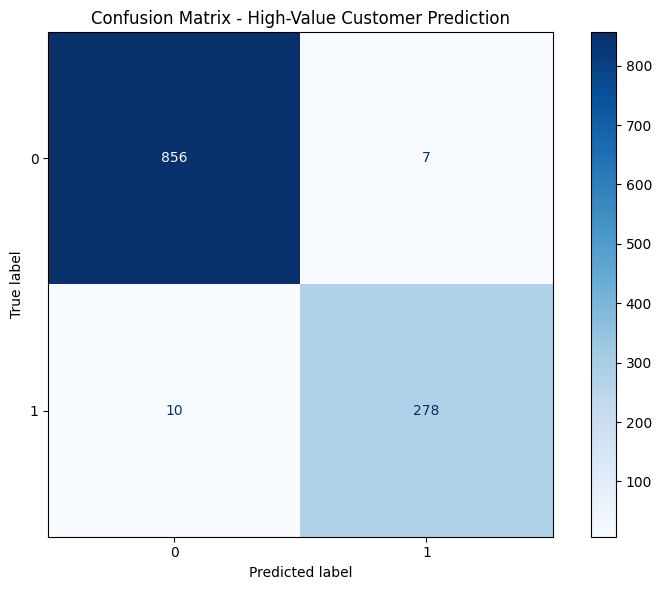

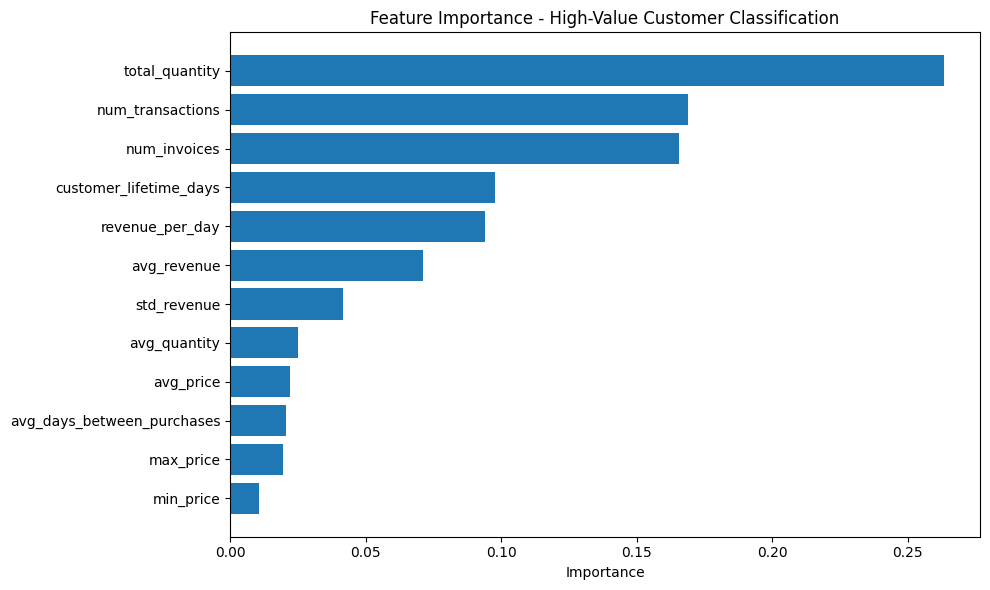

In [17]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# ==============================
# PREDICTIVE ANALYTICS: CLASSIFICATION
# Predict High-Value Customers
# ==============================

# Use same customer_features from above, create binary target
threshold = customer_features['total_revenue'].quantile(0.75)  # Top 25% are high-value
customer_features['is_high_value'] = (customer_features['total_revenue'] > threshold).astype(int)

print(f"High-value threshold: ${threshold:,.2f}")
print(f"High-value customers: {customer_features['is_high_value'].sum()} ({customer_features['is_high_value'].mean()*100:.1f}%)")

X = customer_features[feature_columns]
y = customer_features['is_high_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n" + "="*50)
print("COMPARING CLASSIFICATION MODELS")
print("="*50)

# 1. Logistic Regression
lr_clf = LogisticRegression(random_state=42, max_iter=1000)
lr_clf.fit(X_train_scaled, y_train)
lr_pred = lr_clf.predict(X_test_scaled)
lr_acc = accuracy_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_clf.predict_proba(X_test_scaled)[:, 1])
print(f"\nLogistic Regression Accuracy: {lr_acc:.4f}, AUC: {lr_auc:.4f}")

# 2. Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
rf_acc = accuracy_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_clf.predict_proba(X_test)[:, 1])
print(f"Random Forest Accuracy: {rf_acc:.4f}, AUC: {rf_auc:.4f}")

# 3. Gradient Boosting
gb_clf = GradientBoostingClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_acc = accuracy_score(y_test, gb_pred)
gb_auc = roc_auc_score(y_test, gb_clf.predict_proba(X_test)[:, 1])
print(f"Gradient Boosting Accuracy: {gb_acc:.4f}, AUC: {gb_auc:.4f}")

# 4. XGBoost
xgb_clf = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42)
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_auc = roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1])
print(f"XGBoost Accuracy: {xgb_acc:.4f}, AUC: {xgb_auc:.4f}")

print("\n" + "="*50)
print("CLASSIFICATION REPORT (Random Forest)")
print("="*50)
print(classification_report(y_test, rf_pred, target_names=['Standard', 'High-Value']))

# Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay
fig, ax = plt.subplots(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, rf_pred, ax=ax, cmap='Blues')
plt.title('Confusion Matrix - High-Value Customer Prediction')
plt.tight_layout()
plt.show()

# Feature Importance
feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': rf_clf.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance - High-Value Customer Classification')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

RFM Summary:
        customer_id      recency     frequency       monetary
count   5852.000000  5852.000000   5852.000000    5852.000000
mean   15319.707109   200.732399    137.125427    2978.895593
std     1714.929942   208.523287    352.868243   14604.546365
min    12346.000000     1.000000      1.000000       2.950000
25%    13837.750000    26.000000     21.000000     344.890000
50%    15320.500000    96.000000     53.000000     880.375000
75%    16802.250000   380.000000    142.000000    2289.335000
max    18287.000000   739.000000  12879.000000  608821.650000


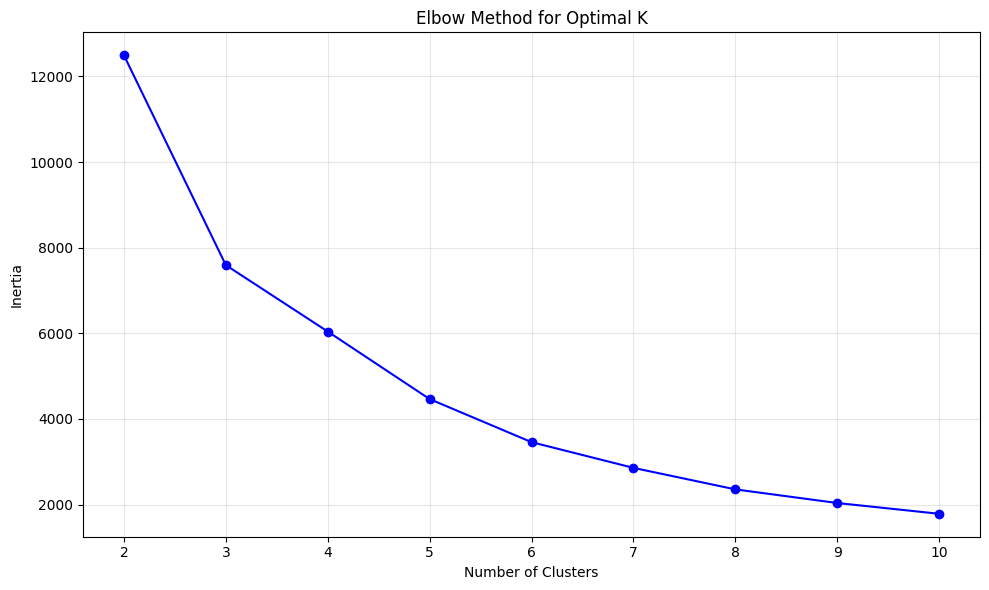


CUSTOMER SEGMENTATION (4 CLUSTERS)

Cluster 0 (n=1979):
  Avg Recency: 462 days
  Avg Frequency: 43.8 orders
  Avg Monetary: $775.78

Cluster 1 (n=3861):
  Avg Recency: 67 days
  Avg Frequency: 169.9 orders
  Avg Monetary: $3,428.96

Cluster 2 (n=6):
  Avg Recency: 5 days
  Avg Frequency: 2123.5 orders
  Avg Monetary: $343,035.21

Cluster 3 (n=6):
  Avg Recency: 2 days
  Avg Frequency: 7868.5 orders
  Avg Monetary: $99,968.61


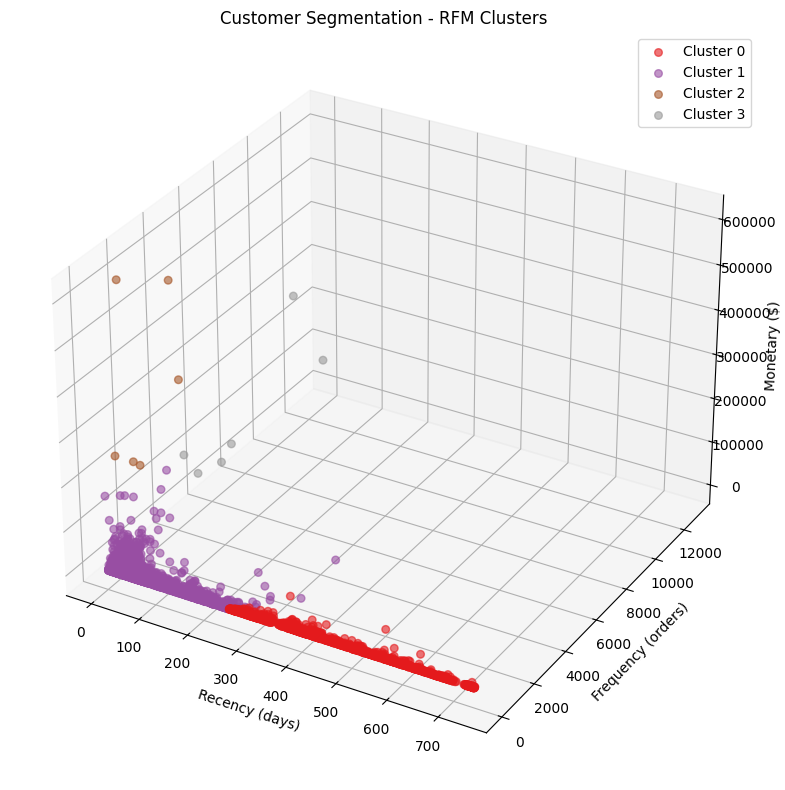

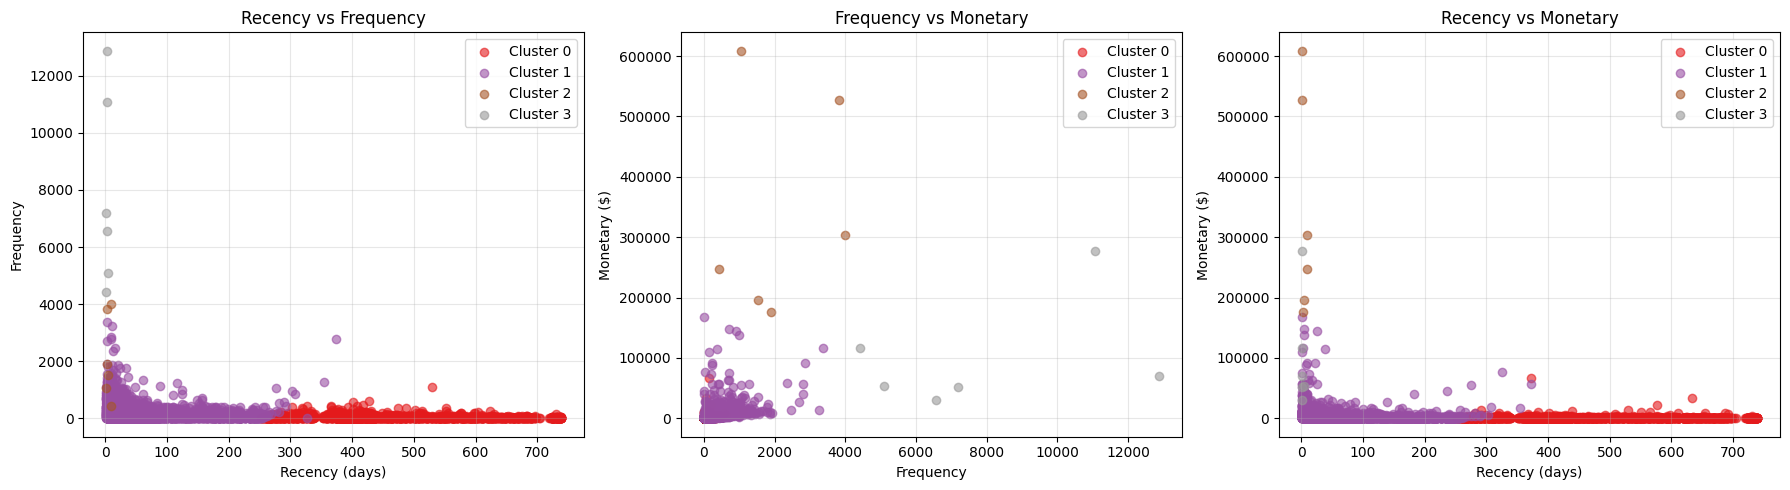

In [18]:
# ==============================
# PREDICTIVE ANALYTICS: CLUSTERING
# RFM Customer Segmentation
# ==============================

# Calculate RFM (Recency, Frequency, Monetary)
# Convert to Timestamp explicitly
from sklearn.cluster import KMeans


reference_date = pd.to_datetime(df['invoicedate'].max()) + pd.Timedelta(days=1)

rfm = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'invoicedate': lambda x: (reference_date - pd.to_datetime(x.max())).days,  # Convert x.max() to Timestamp
    'salesid': 'count',  # Frequency
    'revenue': 'sum'  # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']

print("RFM Summary:")
print(rfm.describe())

# Normalize for clustering
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])

# Elbow method to find optimal clusters
inertias = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply K-Means with optimal clusters (e.g., 4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm['cluster'] = kmeans.fit_predict(rfm_scaled)

print(f"\n" + "="*50)
print(f"CUSTOMER SEGMENTATION ({optimal_k} CLUSTERS)")
print("="*50)

# Analyze clusters
for i in range(optimal_k):
    cluster_data = rfm[rfm['cluster'] == i]
    print(f"\nCluster {i} (n={len(cluster_data)}):")
    print(f"  Avg Recency: {cluster_data['recency'].mean():.0f} days")
    print(f"  Avg Frequency: {cluster_data['frequency'].mean():.1f} orders")
    print(f"  Avg Monetary: ${cluster_data['monetary'].mean():,.2f}")

# Visualize clusters (3D)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = plt.cm.Set1(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    cluster_data = rfm[rfm['cluster'] == i]
    ax.scatter(cluster_data['recency'], cluster_data['frequency'], 
               cluster_data['monetary'], c=[colors[i]], 
               label=f'Cluster {i}', alpha=0.6, s=30)

ax.set_xlabel('Recency (days)')
ax.set_ylabel('Frequency (orders)')
ax.set_zlabel('Monetary ($)')
ax.set_title('Customer Segmentation - RFM Clusters')
ax.legend()
plt.tight_layout()
plt.show()

# 2D views
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Recency vs Frequency
for i in range(optimal_k):
    cluster_data = rfm[rfm['cluster'] == i]
    axes[0].scatter(cluster_data['recency'], cluster_data['frequency'], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6)
axes[0].set_xlabel('Recency (days)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Frequency vs Monetary
for i in range(optimal_k):
    cluster_data = rfm[rfm['cluster'] == i]
    axes[1].scatter(cluster_data['frequency'], cluster_data['monetary'], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6)
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Monetary ($)')
axes[1].set_title('Frequency vs Monetary')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Recency vs Monetary
for i in range(optimal_k):
    cluster_data = rfm[rfm['cluster'] == i]
    axes[2].scatter(cluster_data['recency'], cluster_data['monetary'], 
                    c=[colors[i]], label=f'Cluster {i}', alpha=0.6)
axes[2].set_xlabel('Recency (days)')
axes[2].set_ylabel('Monetary ($)')
axes[2].set_title('Recency vs Monetary')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## RFM Clustering

__Cluster 0__
- Inactive, low engagement
- At risk or churned - reactive

__Cluster 1__
- Active, high-value customers
- Core segment - retain with loyalty rewards, early access

__Cluster 2__
- Whale customer (1)
- Extreme frequency (2123), massive spend (£343K)
- Likely reseller or corporate buyer - treat as key account

__Cluster 3__
- Whale customer (2)
- Even higher frequency (7868), but lower spend (£99K)

### Elbow Plot
Inertia drops until k=4 which indicates 4 clusters as optimal as there's diminishing returns after more clusters

### 3D & 2D Scatter Plots
- __Recency vs. Frequency__:  
    Most customers clusters at low frequency, high recency. Cluster 1 stands out as dense, frequent, recent. First time discoverers, or not coming back?
- __Frequency vs. Monetary__
    Strong, positive correlation. The more orders, the more spend. Whales (C2, C3) are extreme outliers. This focus on whales corresponds with the focus on [Take-Two Interactive annual reposts](https://taketwointeractivesoftwareinc.gcs-web.com/financial-information/annual-reports) and similar microtransaction based games.
- __Recency vs. Monetary__  
    There is no clear trend. Recent purchase does not guarantee high spend.

### Key Insights
- Two whales dominates. Extreme skew. Over-reliance on 6 customers. 
- 1979 customers have not bought anything in 15 months.
- 3861 active valuable customers. Protect and grow.
- Frequency drives monetary. Recency is weakly linked. Need incentives to convert recent buyers. Micro-discounts? "Points" for buying more?



Building customer segmentation...


C:\Users\user\AppData\Local\Temp\ipykernel_28448\2899813040.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  customer_seg['std_transaction'].fillna(0, inplace=True)


K=3, Silhouette Score: 0.421
K=4, Silhouette Score: 0.393
K=5, Silhouette Score: 0.434
K=6, Silhouette Score: 0.432
K=7, Silhouette Score: 0.435


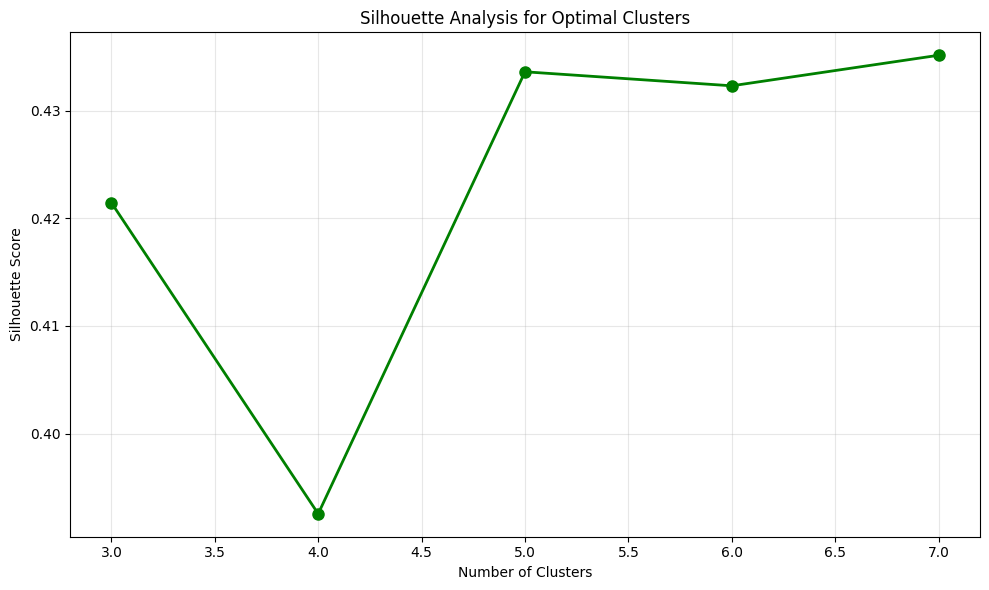


CUSTOMER SEGMENTATION ANALYSIS
         Count  Avg_Recency  Avg_Revenue  Total_Revenue  Avg_Orders  \
segment                                                               
0         1783       481.92       726.69     1295686.47       40.54   
1          420        38.83     12316.52     5172939.10      703.68   
2           14         3.86    204706.16     2865886.25     4726.93   
3         1598        95.33       859.44     1373383.67       48.46   
4         2037        72.03      3301.23     6724601.52      142.86   

         Avg_Products  Avg_Lifetime  Revenue_Share_%  
segment                                               
0               33.68         70.83              7.4  
1              347.22        610.39             29.7  
2             1202.57        667.64             16.4  
3               40.18         85.15              7.9  
4               94.93        530.24             38.6  

SEGMENT NAMES & DESCRIPTIONS

Segment 0: At Risk
  Customers: 1783 (30.5%)
  Avg Rec

C:\Users\user\AppData\Local\Temp\ipykernel_28448\2899813040.py:144: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1, 1].boxplot(seg_data_list, labels=[segment_names[i] for i in range(n_segments)], patch_artist=True)


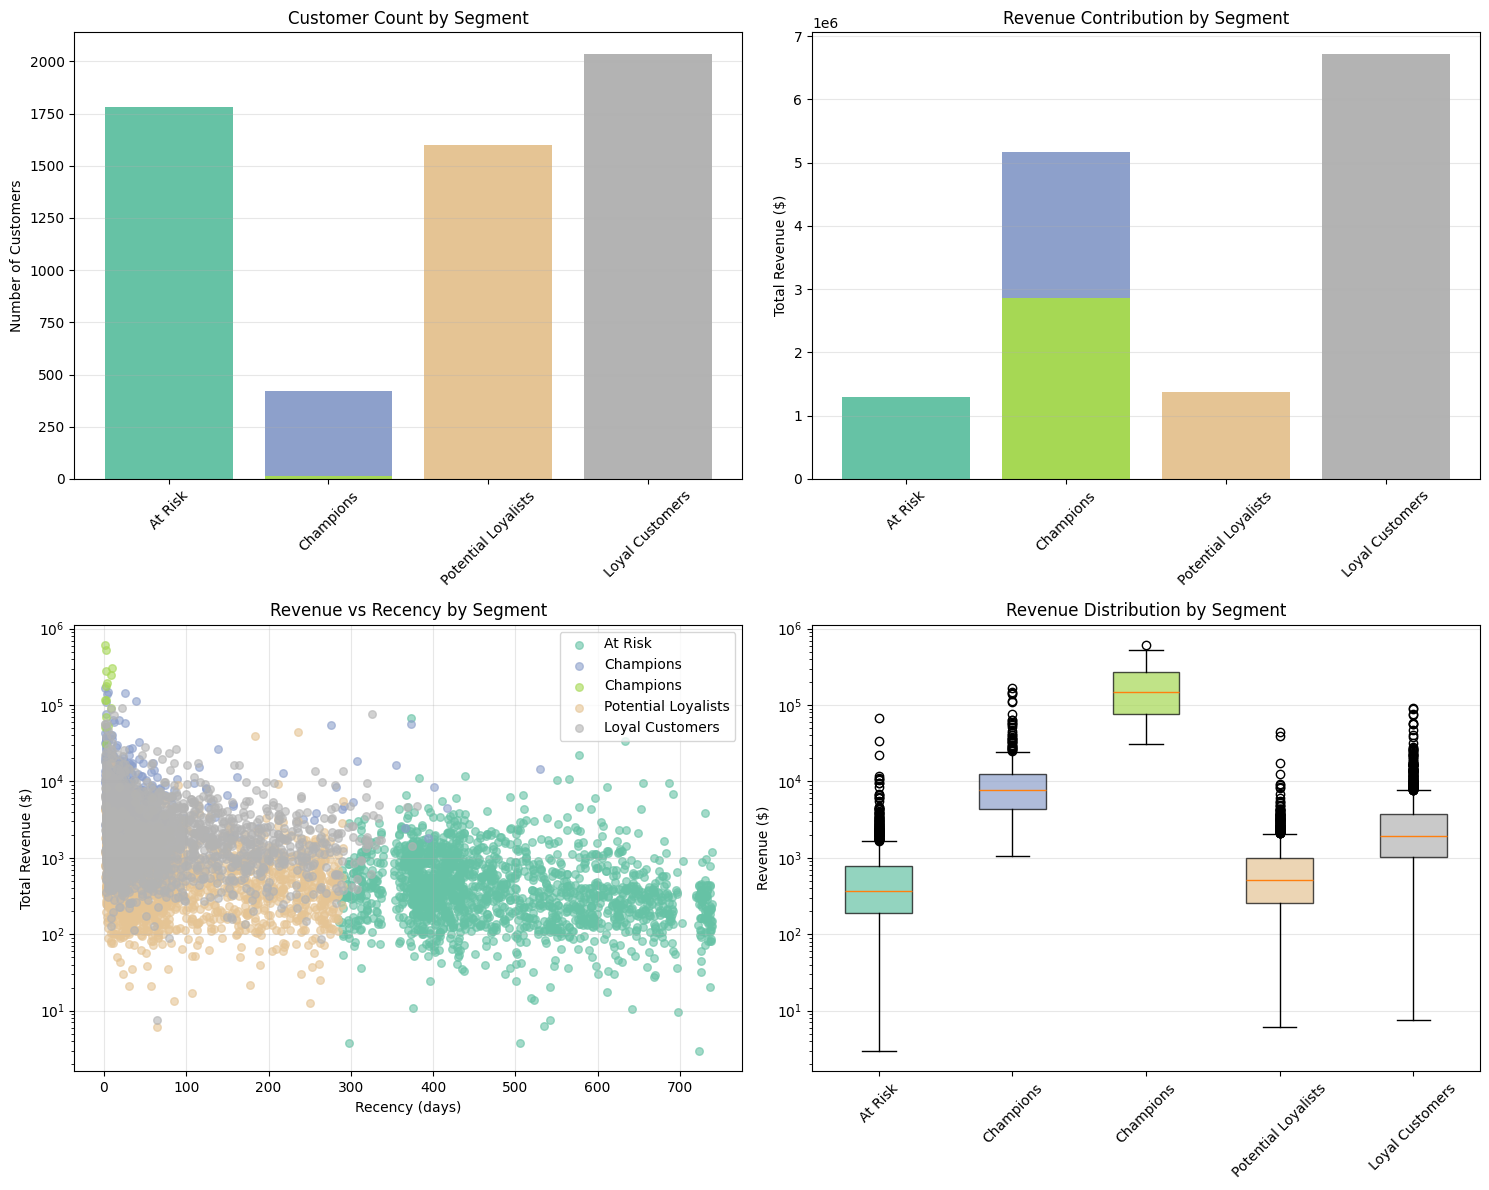

In [19]:
# ==============================
# ENHANCED CUSTOMER SEGMENTATION
# ==============================

from sklearn.cluster import KMeans

# Calculate comprehensive customer metrics
print("Building customer segmentation...")
customer_seg = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'invoicedate': lambda x: (reference_date - pd.to_datetime(x.max())).days,
    'salesid': ['count', 'nunique'],
    'revenue': ['sum', 'mean', 'std'],
    'quantity': 'sum',
    'description': 'nunique'  # product diversity
}).reset_index()

customer_seg.columns = ['customer_id', 'recency', 'total_transactions', 'unique_orders', 
                        'total_revenue', 'avg_transaction', 'std_transaction', 
                        'total_quantity', 'product_diversity']

customer_seg['std_transaction'].fillna(0, inplace=True)

# Calculate customer lifetime
customer_lifetime = df[df['Customer ID'] != 0].groupby('Customer ID')['invoicedate'].agg(['min', 'max']).reset_index()
customer_lifetime['lifetime_days'] = (pd.to_datetime(customer_lifetime['max']) - pd.to_datetime(customer_lifetime['min'])).dt.days + 1
customer_seg = customer_seg.merge(customer_lifetime[['Customer ID', 'lifetime_days']], 
                                   left_on='customer_id', right_on='Customer ID', how='left')
customer_seg.drop('Customer ID', axis=1, inplace=True)

# Segment using multiple features
seg_features = ['recency', 'total_revenue', 'unique_orders', 'product_diversity', 'lifetime_days']
seg_scaled = StandardScaler().fit_transform(customer_seg[seg_features])

# Determine optimal clusters using silhouette score
from sklearn.metrics import silhouette_score

silhouette_scores = []
K_range = range(3, 8)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(seg_scaled)
    score = silhouette_score(seg_scaled, labels)
    silhouette_scores.append(score)
    print(f"K={k}, Silhouette Score: {score:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal Clusters')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Apply K-Means with 5 clusters
n_segments = 5
kmeans = KMeans(n_clusters=n_segments, random_state=42, n_init=10)
customer_seg['segment'] = kmeans.fit_predict(seg_scaled)

# Analyze and name segments
print("\n" + "="*70)
print("CUSTOMER SEGMENTATION ANALYSIS")
print("="*70)

segment_profiles = customer_seg.groupby('segment').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'total_revenue': ['mean', 'sum'],
    'unique_orders': 'mean',
    'product_diversity': 'mean',
    'lifetime_days': 'mean'
}).round(2)

segment_profiles.columns = ['Count', 'Avg_Recency', 'Avg_Revenue', 'Total_Revenue', 
                            'Avg_Orders', 'Avg_Products', 'Avg_Lifetime']

# Calculate revenue contribution
segment_profiles['Revenue_Share_%'] = (segment_profiles['Total_Revenue'] / 
                                       segment_profiles['Total_Revenue'].sum() * 100).round(1)

print(segment_profiles)

# Name segments based on characteristics
def name_segment(row):
    if row['Avg_Recency'] < 50 and row['Avg_Revenue'] > 3000:
        return "Champions"
    elif row['Avg_Recency'] < 100 and row['Avg_Revenue'] > 2000:
        return "Loyal Customers"
    elif row['Avg_Recency'] > 300 and row['Avg_Revenue'] < 1000:
        return "At Risk"
    elif row['Avg_Recency'] > 200 and row['Avg_Orders'] < 30:
        return "Hibernating"
    else:
        return "Potential Loyalists"

segment_names = segment_profiles.apply(name_segment, axis=1)
print("\n" + "="*70)
print("SEGMENT NAMES & DESCRIPTIONS")
print("="*70)
for seg_id, name in segment_names.items():
    seg_data = segment_profiles.loc[seg_id]
    print(f"\nSegment {seg_id}: {name}")
    print(f"  Customers: {int(seg_data['Count'])} ({seg_data['Count']/customer_seg.shape[0]*100:.1f}%)")
    print(f"  Avg Recency: {seg_data['Avg_Recency']:.0f} days")
    print(f"  Avg Revenue: ${seg_data['Avg_Revenue']:,.0f}")
    print(f"  Revenue Share: {seg_data['Revenue_Share_%']:.1f}%")
    print(f"  Avg Orders: {seg_data['Avg_Orders']:.0f}")
    print(f"  Avg Product Diversity: {seg_data['Avg_Products']:.0f}")

# Visualization: Segment Distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Customer count by segment
seg_counts = customer_seg['segment'].value_counts().sort_index()
colors_seg = plt.cm.Set2(np.linspace(0, 1, n_segments))
axes[0, 0].bar([segment_names[i] for i in seg_counts.index], seg_counts.values, color=colors_seg)
axes[0, 0].set_ylabel('Number of Customers')
axes[0, 0].set_title('Customer Count by Segment')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Revenue by segment
seg_revenue = customer_seg.groupby('segment')['total_revenue'].sum().sort_index()
axes[0, 1].bar([segment_names[i] for i in seg_revenue.index], seg_revenue.values, color=colors_seg)
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].set_title('Revenue Contribution by Segment')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Scatter: Revenue vs Recency
for i in range(n_segments):
    seg_data = customer_seg[customer_seg['segment'] == i]
    axes[1, 0].scatter(seg_data['recency'], seg_data['total_revenue'], 
                      alpha=0.6, s=30, label=segment_names[i], color=colors_seg[i])
axes[1, 0].set_xlabel('Recency (days)')
axes[1, 0].set_ylabel('Total Revenue ($)')
axes[1, 0].set_title('Revenue vs Recency by Segment')
axes[1, 0].set_yscale('log')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot: Revenue distribution
seg_data_list = [customer_seg[customer_seg['segment'] == i]['total_revenue'].values for i in range(n_segments)]
bp = axes[1, 1].boxplot(seg_data_list, labels=[segment_names[i] for i in range(n_segments)], patch_artist=True)
for patch, color in zip(bp['boxes'], colors_seg):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1, 1].set_ylabel('Revenue ($)')
axes[1, 1].set_title('Revenue Distribution by Segment')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].set_yscale('log')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Enhanced Customer Segmentation Findings
The column charts, scatter plots and candle stick charts are self explanatory. 

Using the silhoutte score, the silhouette diagram shows how cluster quality changes with the number of clusters $K$. This is useful because it avoids arbitrary decisions, and it balances fit and simplicity. $K=7$ is slightly better, but $K=5$ is more interpretable and nearly identical. Easier to act on 5 segments than 7.

### Customer Segmentation Analysis Print Findings

__Segment 0: At risk__  
    $30,5\%$ of customers have been seen about 15 months ago. They are effectively churned.

__Segment 1: Champions__  
    $7,2\%$ of base equals $29,7\%$ of revenue. Very R (recent (39d)), F (high frequency (704)) with high product diversity (347). Prime targets, keep engaged.

__Segment 2: Champions__  
    Only 14 customers, but $16,4\%$ of revenue! 4727 order, £204K spend, 1203 unique products. Likely wholesale resellers. Retain.

__Segment 3: Potential Loyalists__  
    $27,3\%$ of base, recent 95 days, low spend/diversity. Upsell opportunity. 

__Segment 4: Loyalists__  
    The revenue engine. $34,8\%$ of customers are $38,6\%$ of total revenue. Most stable segment. Retain.

__Action__:
- Protect __S1__ and __S2__: assign key account managers, prevent churn.
- Grow __S3__ and __S4__: Use cross-selling to increase order frequency (for revenue).
- Sunset __S0__: Low ROI on reactivation.
- Investigate S2: Might be resellers or automated buyers. Validate legitimacy.

In [20]:
# ==============================
# DETAILED RFM ANALYSIS WITH SCORING
# ==============================

print("\n" + "="*70)
print("RFM ANALYSIS WITH QUINTILE SCORING")
print("="*70)

# Calculate RFM
reference_date = pd.to_datetime(df['invoicedate'].max()) + pd.Timedelta(days=1)

rfm_detailed = df[df['Customer ID'] != 0].groupby('Customer ID').agg({
    'invoicedate': lambda x: (reference_date - pd.to_datetime(x.max())).days,
    'salesid': 'count',
    'revenue': 'sum'
}).reset_index()

rfm_detailed.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Create RFM scores (1-5, where 5 is best)
rfm_detailed['R_score'] = pd.qcut(rfm_detailed['recency'], 5, labels=[5, 4, 3, 2, 1])  # Lower recency is better
rfm_detailed['F_score'] = pd.qcut(rfm_detailed['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_detailed['M_score'] = pd.qcut(rfm_detailed['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Convert to numeric
rfm_detailed['R_score'] = rfm_detailed['R_score'].astype(int)
rfm_detailed['F_score'] = rfm_detailed['F_score'].astype(int)
rfm_detailed['M_score'] = rfm_detailed['M_score'].astype(int)

# Calculate RFM total score
rfm_detailed['RFM_score'] = rfm_detailed['R_score'] + rfm_detailed['F_score'] + rfm_detailed['M_score']
rfm_detailed['RFM_segment'] = rfm_detailed['R_score'].astype(str) + rfm_detailed['F_score'].astype(str) + rfm_detailed['M_score'].astype(str)

# Define segment categories based on RFM scores
def categorize_rfm(row):
    r, f, m = row['R_score'], row['F_score'], row['M_score']
    
    if r >= 4 and f >= 4 and m >= 4:
        return "Champions"
    elif r >= 3 and f >= 3 and m >= 3:
        return "Loyal Customers"
    elif r >= 4 and f <= 2:
        return "New Customers"
    elif r >= 3 and f <= 2 and m >= 3:
        return "Promising"
    elif r <= 2 and f >= 3:
        return "At Risk"
    elif r <= 2 and f <= 2 and m >= 3:
        return "Can't Lose Them"
    elif r <= 2 and f <= 2 and m <= 2:
        return "Lost"
    else:
        return "Need Attention"

rfm_detailed['rfm_category'] = rfm_detailed.apply(categorize_rfm, axis=1)

# Summary statistics by RFM category
rfm_summary = rfm_detailed.groupby('rfm_category').agg({
    'customer_id': 'count',
    'recency': 'mean',
    'frequency': 'mean',
    'monetary': ['mean', 'sum']
}).round(2)

rfm_summary.columns = ['Customer_Count', 'Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue']
rfm_summary['Revenue_Share_%'] = (rfm_summary['Total_Revenue'] / rfm_summary['Total_Revenue'].sum() * 100).round(1)
rfm_summary = rfm_summary.sort_values('Total_Revenue', ascending=False)

print("\nRFM CATEGORY BREAKDOWN:")
print(rfm_summary)

# Top customers analysis
print("\n" + "="*70)
print("TOP 20 CUSTOMERS (By RFM Score)")
print("="*70)
top_customers = rfm_detailed.nlargest(20, 'RFM_score')[['customer_id', 'recency', 'frequency', 'monetary', 
                                                         'R_score', 'F_score', 'M_score', 'RFM_score', 'rfm_category']]
print(top_customers.to_string(index=False))

print()
print()


RFM ANALYSIS WITH QUINTILE SCORING

RFM CATEGORY BREAKDOWN:
                 Customer_Count  Avg_Recency  Avg_Frequency  Avg_Monetary  \
rfm_category                                                                
Champions                  1262        20.27         400.33       9269.03   
Loyal Customers            1147        72.11         127.33       2254.56   
At Risk                     916       389.52         105.20       1716.36   
New Customers               490        27.30          19.76       1053.00   
Can't Lose Them             198       394.62          22.57       1955.39   
Lost                       1225       457.69          15.28        256.30   
Promising                   105       104.90          22.69       1767.24   
Need Attention              509        91.15          38.47        342.14   

                 Total_Revenue  Revenue_Share_%  
rfm_category                                     
Champions          11697511.69             67.1  
Loyal Customers   

__RFM ANALYSIS WITH QUENTILE SCORING__ 
- RFM analysis is a classic customer segmentation technique that helps buisnesses identify behavior and value.

R (Recency): How recently a customer made a purchase
F (Frequency): How often they make purchases
M (Monetary): How much money they spend

- In our charts it devides the customers into different categories based on how much they spend, how often they spend and when they last purchased something.


__TOP 20 CUSTOMERS (By RFM Score)__
-  Shows the top 20 customers (customer_id) by RFM score

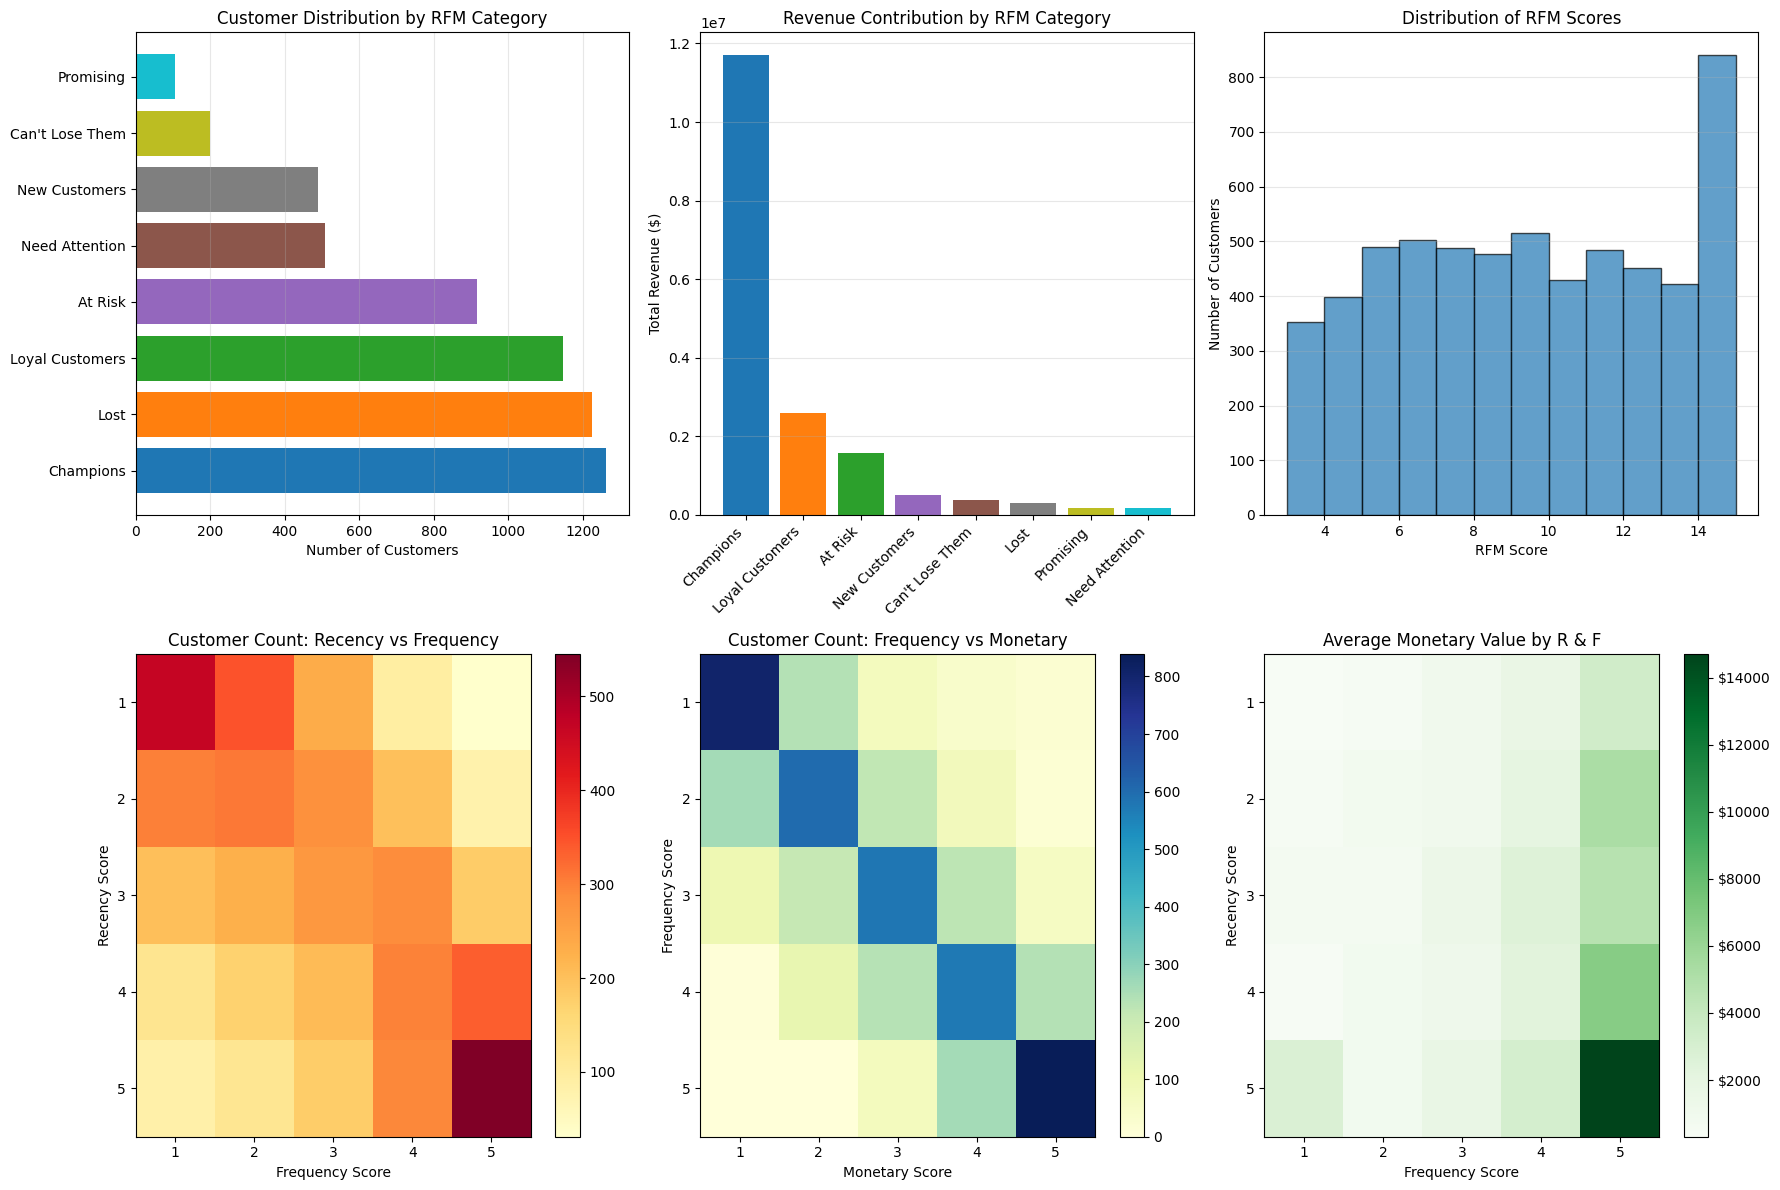

In [21]:
# RFM VISUALIZATIONS
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Customer distribution by RFM category
cat_counts = rfm_detailed['rfm_category'].value_counts()
colors_rfm = plt.cm.tab10(np.linspace(0, 1, len(cat_counts)))
axes[0, 0].barh(cat_counts.index, cat_counts.values, color=colors_rfm)
axes[0, 0].set_xlabel('Number of Customers')
axes[0, 0].set_title('Customer Distribution by RFM Category')
axes[0, 0].grid(True, alpha=0.3, axis='x')

# 2. Revenue by RFM category
cat_revenue = rfm_detailed.groupby('rfm_category')['monetary'].sum().sort_values(ascending=False)
axes[0, 1].bar(range(len(cat_revenue)), cat_revenue.values, color=colors_rfm)
axes[0, 1].set_xticks(range(len(cat_revenue)))
axes[0, 1].set_xticklabels(cat_revenue.index, rotation=45, ha='right')
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].set_title('Revenue Contribution by RFM Category')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. RFM Score Distribution
axes[0, 2].hist(rfm_detailed['RFM_score'], bins=range(3, 16), edgecolor='black', alpha=0.7)
axes[0, 2].set_xlabel('RFM Score')
axes[0, 2].set_ylabel('Number of Customers')
axes[0, 2].set_title('Distribution of RFM Scores')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Heatmap: R vs F
rfm_pivot_rf = rfm_detailed.groupby(['R_score', 'F_score']).size().unstack(fill_value=0)
im1 = axes[1, 0].imshow(rfm_pivot_rf.values, cmap='YlOrRd', aspect='auto')
axes[1, 0].set_xticks(range(5))
axes[1, 0].set_yticks(range(5))
axes[1, 0].set_xticklabels(range(1, 6))
axes[1, 0].set_yticklabels(range(1, 6))
axes[1, 0].set_xlabel('Frequency Score')
axes[1, 0].set_ylabel('Recency Score')
axes[1, 0].set_title('Customer Count: Recency vs Frequency')
plt.colorbar(im1, ax=axes[1, 0])

# 5. Heatmap: F vs M
rfm_pivot_fm = rfm_detailed.groupby(['F_score', 'M_score']).size().unstack(fill_value=0)
im2 = axes[1, 1].imshow(rfm_pivot_fm.values, cmap='YlGnBu', aspect='auto')
axes[1, 1].set_xticks(range(5))
axes[1, 1].set_yticks(range(5))
axes[1, 1].set_xticklabels(range(1, 6))
axes[1, 1].set_yticklabels(range(1, 6))
axes[1, 1].set_xlabel('Monetary Score')
axes[1, 1].set_ylabel('Frequency Score')
axes[1, 1].set_title('Customer Count: Frequency vs Monetary')
plt.colorbar(im2, ax=axes[1, 1])

# 6. Average Monetary by R and F scores
rfm_monetary_avg = rfm_detailed.groupby(['R_score', 'F_score'])['monetary'].mean().unstack(fill_value=0)
im3 = axes[1, 2].imshow(rfm_monetary_avg.values, cmap='Greens', aspect='auto')
axes[1, 2].set_xticks(range(5))
axes[1, 2].set_yticks(range(5))
axes[1, 2].set_xticklabels(range(1, 6))
axes[1, 2].set_yticklabels(range(1, 6))
axes[1, 2].set_xlabel('Frequency Score')
axes[1, 2].set_ylabel('Recency Score')
axes[1, 2].set_title('Average Monetary Value by R & F')
plt.colorbar(im3, ax=axes[1, 2], format='$%.0f')

plt.tight_layout()
plt.show()

__Customer distribution by RFM Category__
- Shows the new categories created from the RFM calculation in a chart format. It shows numbers of customers in each category.

__Revenue Contribution by RFM Category__
- Shows the categories in relation to their revenue contribution.

__Distribution of RFM Scores__
- Shows the number of customers and how they are distributed in relation to the RFM scores.

__Customer Count: Recency vs Frequency__
- A heatmap showing the how "recency" and "frequency" values are connected. The results indicate that "most people" show up in either:

Top-left (Recency 1, Frequency 1): Customers who have not bought in a long time and buy rarely.
Bottom-right (Recency 5, Frequency 5): Loyal and recently active customers.

__Customer Count: Frequency vs Monetary__
- A heatmap showing the how "frequency" and "monetary" values are connected. The results indicates:

The bottom-right (5,5) corner — dark blue — represents customers who buy often and spend a lot. These are your best / most valuable customers.
The top-left (1,1) corner — also dark — indicates many customers buy rarely and spend little. This could be a large but low-value group.
The diagonal pattern (dark colors along from top-left to bottom-right) suggests a positive relationship between frequency and spending: those who buy more also tend to spend more.

__Average Monetary Value By R & F__
- A heatmap showing the how "recency" and "frequency" values are connected. The results indicates:


Darker areas (bottom-right) — customers who are both recent and frequent buyers — have the highest spending.
Lighter areas (top-left) — customers who bought long ago and rarely — have low average spending.
This pattern indicates a strong positive link: the more often and recently someone buys, the higher their total spend value tends to be.




In [22]:
# ==============================
# INTERNATIONAL SALES PATTERNS ANALYSIS
# ==============================

print("\n" + "="*70)
print("INTERNATIONAL SALES PATTERNS")
print("="*70)

# Prepare data
df['InvoiceDate'] = pd.to_datetime(df['invoicedate'])
df['year_month'] = df['InvoiceDate'].dt.to_period('M')
df['quarter'] = df['InvoiceDate'].dt.to_period('Q')


INTERNATIONAL SALES PATTERNS


In [23]:

# 1. Growth trends by country
print("\n1. MONTHLY GROWTH TRENDS (Top 10 Countries)")
top_10_countries = df.groupby('country')['revenue'].sum().nlargest(10).index

monthly_country = df[df['country'].isin(top_10_countries)].groupby(['year_month', 'country'])['revenue'].sum().reset_index()
monthly_country['year_month_str'] = monthly_country['year_month'].astype(str)

# Calculate growth rates
growth_rates = []
for country in top_10_countries:
    country_data = monthly_country[monthly_country['country'] == country].sort_values('year_month')
    if len(country_data) > 1:
        first_month_rev = country_data.iloc[0]['revenue']
        last_month_rev = country_data.iloc[-1]['revenue']
        total_months = len(country_data)
        cagr = ((last_month_rev / first_month_rev) ** (1/total_months) - 1) * 100
        growth_rates.append({'country': country, 'monthly_growth_%': cagr, 
                            'total_growth_%': ((last_month_rev - first_month_rev) / first_month_rev * 100)})

growth_df = pd.DataFrame(growth_rates).sort_values('monthly_growth_%', ascending=False)
print(growth_df.to_string(index=False))




1. MONTHLY GROWTH TRENDS (Top 10 Countries)
       country  monthly_growth_%  total_growth_%
     Australia         15.354243     2571.604574
   Switzerland         13.070287     1586.612697
        France          0.430078       11.325589
        Sweden         -0.722460      -16.579040
United Kingdom         -0.970087      -21.628184
   Netherlands         -0.991505      -22.050841
       Germany         -1.001876      -22.254714
          EIRE         -3.835106      -62.380420
       Denmark         -9.527674      -88.950398
         Spain        -12.338898      -96.283166


__Monthly growth trends__
- Shows how much growth the top 10 countries have each month and in total of the datasets duration. (2+ years)

In [24]:
# 2. Seasonality analysis
print("\n2. SEASONALITY ANALYSIS")
df['month_name'] = df['InvoiceDate'].dt.month_name()
seasonal_revenue = df.groupby(['country', 'month_name'])['revenue'].sum().reset_index()

# Calculate seasonal index for top 5 countries
top_5 = df.groupby('country')['revenue'].sum().nlargest(5).index
for country in top_5:
    country_seasonal = seasonal_revenue[seasonal_revenue['country'] == country].copy()  # Add .copy()
    avg_monthly = country_seasonal['revenue'].mean()
    country_seasonal['seasonal_index'] = (country_seasonal['revenue'] / avg_monthly * 100).round(1)
    
    print(f"\n{country} - Seasonal Index (100 = average):")
    month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
                   'July', 'August', 'September', 'October', 'November', 'December']
    for month in month_order:
        month_data = country_seasonal[country_seasonal['month_name'] == month]
        if not month_data.empty:
            print(f"  {month:12s}: {month_data['seasonal_index'].values[0]:6.1f}")


2. SEASONALITY ANALYSIS

United Kingdom - Seasonal Index (100 = average):
  January     :   71.8
  February    :   60.4
  March       :   86.6
  April       :   71.3
  May         :   81.6
  June        :   84.3
  July        :   78.7
  August      :   80.9
  September   :  111.8
  October     :  129.7
  November    :  176.7
  December    :  166.2

EIRE - Seasonal Index (100 = average):
  January     :  153.4
  February    :   62.0
  March       :   76.5
  April       :   58.4
  May         :   69.5
  June        :   82.3
  July        :  146.7
  August      :   82.9
  September   :  149.5
  October     :  126.1
  November    :  114.6
  December    :   78.0

Netherlands - Seasonal Index (100 = average):
  January     :  121.7
  February    :   87.4
  March       :  101.3
  April       :   20.1
  May         :  111.6
  June        :  111.0
  July        :   11.8
  August      :  142.3
  September   :  156.2
  October     :  124.9
  November    :  133.7
  December    :   77.9

Germany -

__SEASONALITY ANALYSIS__

- Shows how the different seasons impact revenue for different countries, this is shown up against the average which is a score of 100.

In [25]:

# 3. Market concentration
print("\n3. MARKET CONCENTRATION (Herfindahl-Hirschman Index)")
country_shares = df.groupby('country')['revenue'].sum()
total_revenue = country_shares.sum()
country_shares_pct = (country_shares / total_revenue * 100)
hhi = (country_shares_pct ** 2).sum()
print(f"HHI: {hhi:.2f} (Low: <1500, Moderate: 1500-2500, High: >2500)")
print(f"\nTop country dominance: {country_shares_pct.nlargest(1).iloc[0]:.1f}%")


3. MARKET CONCENTRATION (Herfindahl-Hirschman Index)
HHI: 7369.36 (Low: <1500, Moderate: 1500-2500, High: >2500)

Top country dominance: 85.7%


__Herfindahl-Hirschman index__
- Calculation show to what degree the market is or is not highly concentrated. 
- The results show that the retailers market is highly concentrated with the top country being 85.7% of the total market.

In [26]:



# 4. Average transaction value by country
print("\n4. AVERAGE TRANSACTION VALUE BY COUNTRY (Top 15)")
avg_transaction = df.groupby('country').agg({
    'revenue': ['mean', 'sum', 'count']
}).reset_index()
avg_transaction.columns = ['country', 'avg_transaction', 'total_revenue', 'num_transactions']
avg_transaction = avg_transaction.sort_values('avg_transaction', ascending=False).head(15)
print(avg_transaction.to_string(index=False))



4. AVERAGE TRANSACTION VALUE BY COUNTRY (Top 15)
       country  avg_transaction  total_revenue  num_transactions
   Netherlands       110.365776      549952.66              4983
         Japan        97.192557       47138.39               485
     Australia        93.291617      168484.66              1806
       Denmark        88.464761       68560.19               775
        Sweden        67.096379       86353.04              1287
      Thailand        40.401842        3070.54                76
     Singapore        39.633012       13158.16               332
     Hong Kong        39.530627       13875.25               351
       Bermuda        36.857059        1253.14                34
          EIRE        36.774190      628875.43             17101
     Lithuania        34.675873        6553.74               189
       Lebanon        33.431228        1905.58                57
Czech Republic        32.780833         786.74                24
        Israel        30.717236       11


**Average transaction value by country**
- This shows which countries that spend the most per individual transaction. Listing the top 15 countries.

C:\Users\user\AppData\Local\Temp\ipykernel_28448\3877323691.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


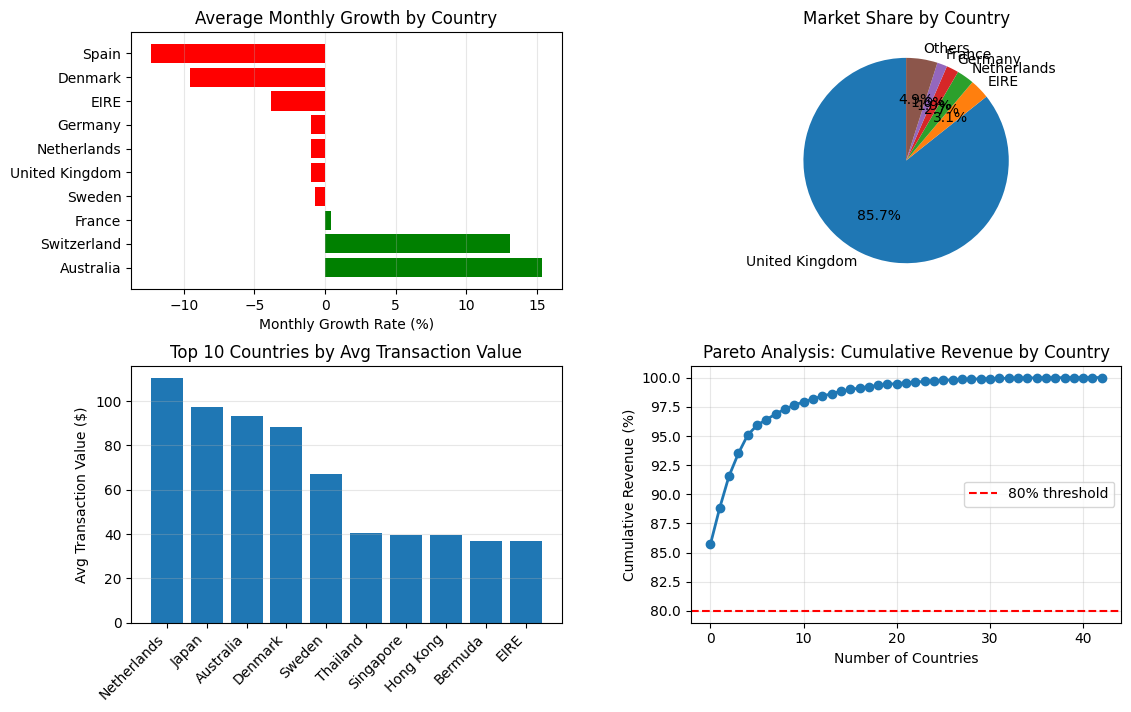

In [27]:
# VISUALIZATIONS
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Growth rates
ax2 = fig.add_subplot(gs[1, 0])
ax2.barh(growth_df['country'], growth_df['monthly_growth_%'], 
         color=['green' if x > 0 else 'red' for x in growth_df['monthly_growth_%']])
ax2.set_xlabel('Monthly Growth Rate (%)')
ax2.set_title('Average Monthly Growth by Country')
ax2.grid(True, alpha=0.3, axis='x')

# 2. Market share pie chart
ax3 = fig.add_subplot(gs[1, 1])
top_5_revenue = country_shares.nlargest(5)
other_revenue = country_shares.sum() - top_5_revenue.sum()
pie_data = list(top_5_revenue.values) + [other_revenue]
pie_labels = list(top_5_revenue.index) + ['Others']
ax3.pie(pie_data, labels=pie_labels, autopct='%1.1f%%', startangle=90)
ax3.set_title('Market Share by Country')

# 3. Transaction value distribution
ax5 = fig.add_subplot(gs[2, 0])
trans_top_10 = avg_transaction.nlargest(10, 'avg_transaction')
ax5.bar(range(len(trans_top_10)), trans_top_10['avg_transaction'].values)
ax5.set_xticks(range(len(trans_top_10)))
ax5.set_xticklabels(trans_top_10['country'].values, rotation=45, ha='right')
ax5.set_ylabel('Avg Transaction Value ($)')
ax5.set_title('Top 10 Countries by Avg Transaction Value')
ax5.grid(True, alpha=0.3, axis='y')

# 4. Cumulative revenue contribution
ax6 = fig.add_subplot(gs[2, 1])
sorted_revenue = country_shares.sort_values(ascending=False)
cumulative_pct = (sorted_revenue.cumsum() / sorted_revenue.sum() * 100)
ax6.plot(range(len(cumulative_pct)), cumulative_pct.values, marker='o', linewidth=2)
ax6.axhline(y=80, color='r', linestyle='--', label='80% threshold')
ax6.set_xlabel('Number of Countries')
ax6.set_ylabel('Cumulative Revenue (%)')
ax6.set_title('Pareto Analysis: Cumulative Revenue by Country')
ax6.legend()
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#Just some quick summaries showing quick statistics in relation to the different:

"Average Monthly Growth by Country"
- Shows the countries with the most and least monthly growth. Australia and Switzerland being the countries with the most growth and Spain and Danmark being the countries with the least.

"Market Share by Country" 
- Shows how much market share each country has in totality, clearly shows that the UK customers are their biggest market share, which makes sense since the retailer is based in the UK.

"Top 10 countries by Average transaction value"
- This shows which countries that spend the most per individual transaction.

"PARETO ANALYSIS"
- You can see that a small number of countries (those at the start of the x-axis) contribute to around 80% of the total revenue, while the remaining countries add relatively little.


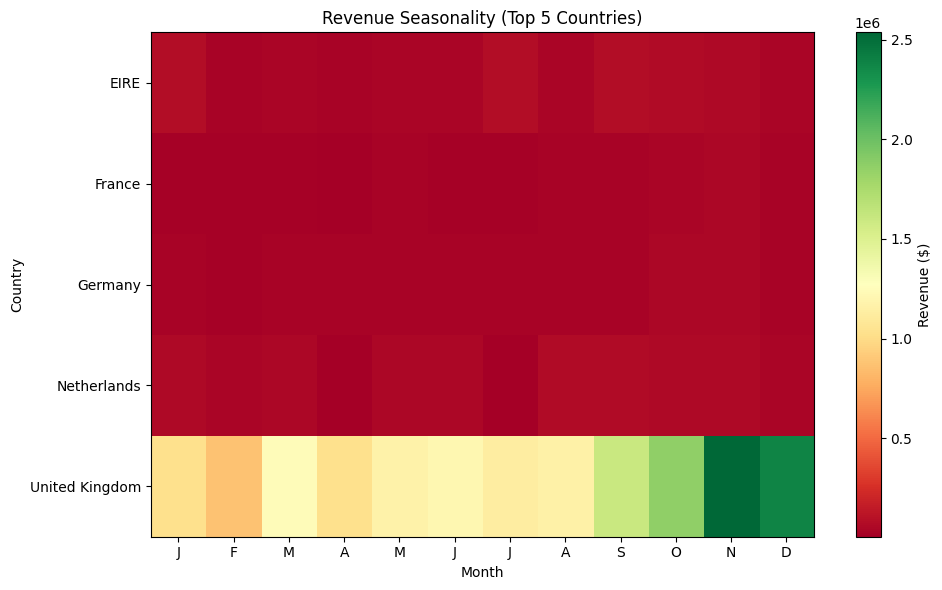

In [28]:
# Revenue Seasonality (Top 5 Countries) - Standalone
plt.figure(figsize=(10, 6))

seasonal_pivot = df.groupby(['country', df['InvoiceDate'].dt.month])['revenue'].sum().reset_index()
seasonal_pivot = seasonal_pivot[seasonal_pivot['country'].isin(top_5)]
seasonal_matrix = seasonal_pivot.pivot(index='country', columns='InvoiceDate', values='revenue')

im = plt.imshow(seasonal_matrix.values, cmap='RdYlGn', aspect='auto')
plt.yticks(range(len(seasonal_matrix.index)), seasonal_matrix.index)
plt.xticks(range(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.xlabel('Month')
plt.ylabel('Country')
plt.title('Revenue Seasonality (Top 5 Countries)')
plt.colorbar(im, label='Revenue ($)')
plt.tight_layout()
plt.show()

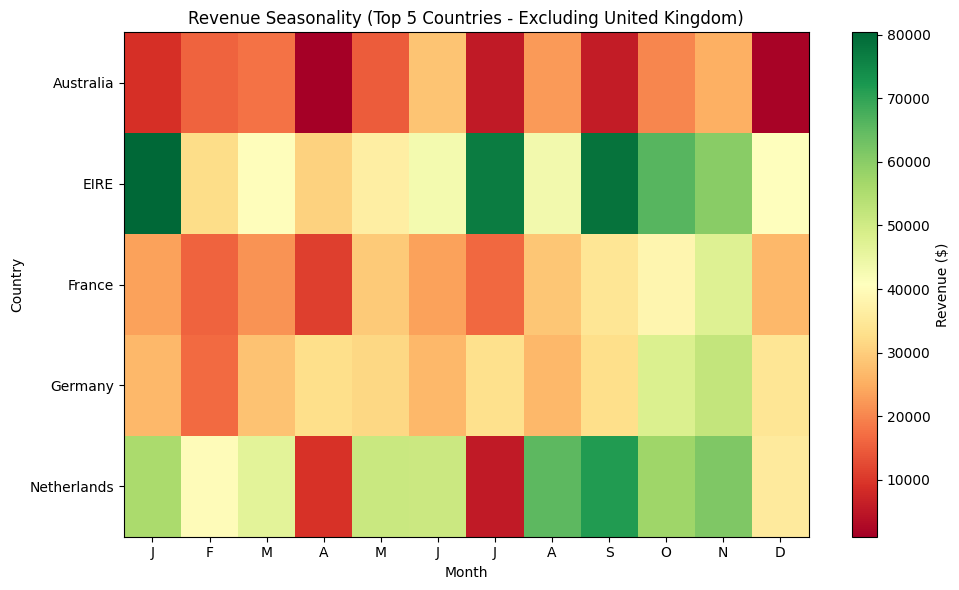

In [35]:
# Revenue Seasonality (Top 5 Countries - Excluding UK) - Standalone
plt.figure(figsize=(10, 6))

# Get top 5 countries excluding UK
non_uk_data = df[df['country'] != 'United Kingdom']
top_5_non_uk = non_uk_data.groupby('country')['revenue'].sum().nlargest(5).index

seasonal_pivot = df.groupby(['country', df['InvoiceDate'].dt.month])['revenue'].sum().reset_index()
seasonal_pivot = seasonal_pivot[seasonal_pivot['country'].isin(top_5_non_uk)]
seasonal_matrix = seasonal_pivot.pivot(index='country', columns='InvoiceDate', values='revenue')

im = plt.imshow(seasonal_matrix.values, cmap='RdYlGn', aspect='auto')
plt.yticks(range(len(seasonal_matrix.index)), seasonal_matrix.index)
plt.xticks(range(12), ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
plt.xlabel('Month')
plt.ylabel('Country')
plt.title('Revenue Seasonality (Top 5 Countries - Excluding United Kingdom)')
plt.colorbar(im, label='Revenue ($)')
plt.tight_layout()
plt.show()

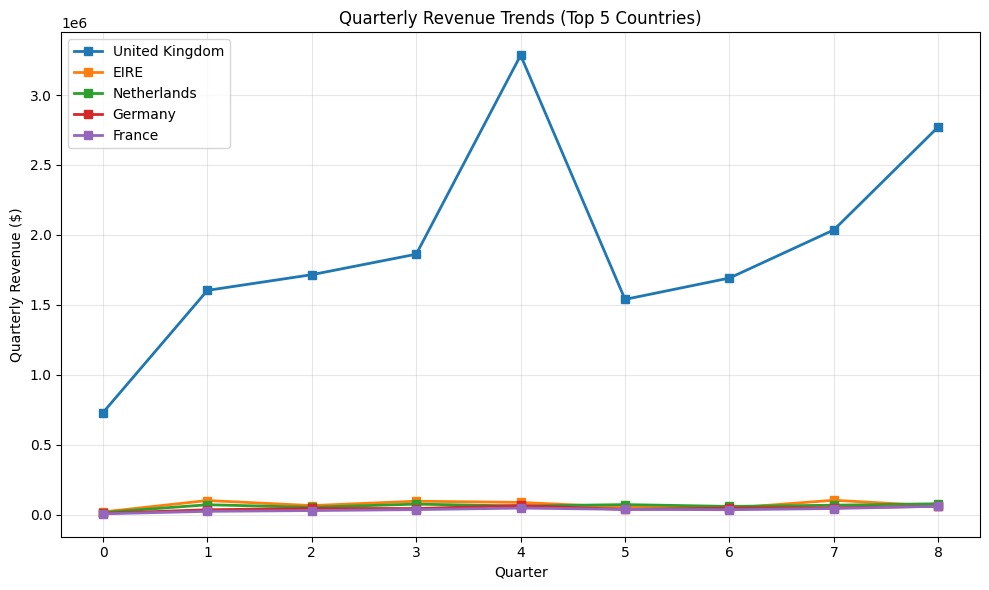

In [29]:
# Quarterly Revenue Trends (Top 5 Countries) - Standalone
plt.figure(figsize=(10, 6))

quarterly_country = df[df['country'].isin(top_5)].groupby(['quarter', 'country'])['revenue'].sum().reset_index()
for country in top_5:
    country_q = quarterly_country[quarterly_country['country'] == country].sort_values('quarter')
    plt.plot(range(len(country_q)), country_q['revenue'].values, marker='s', label=country, linewidth=2)

plt.xlabel('Quarter')
plt.ylabel('Quarterly Revenue ($)')
plt.title('Quarterly Revenue Trends (Top 5 Countries)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

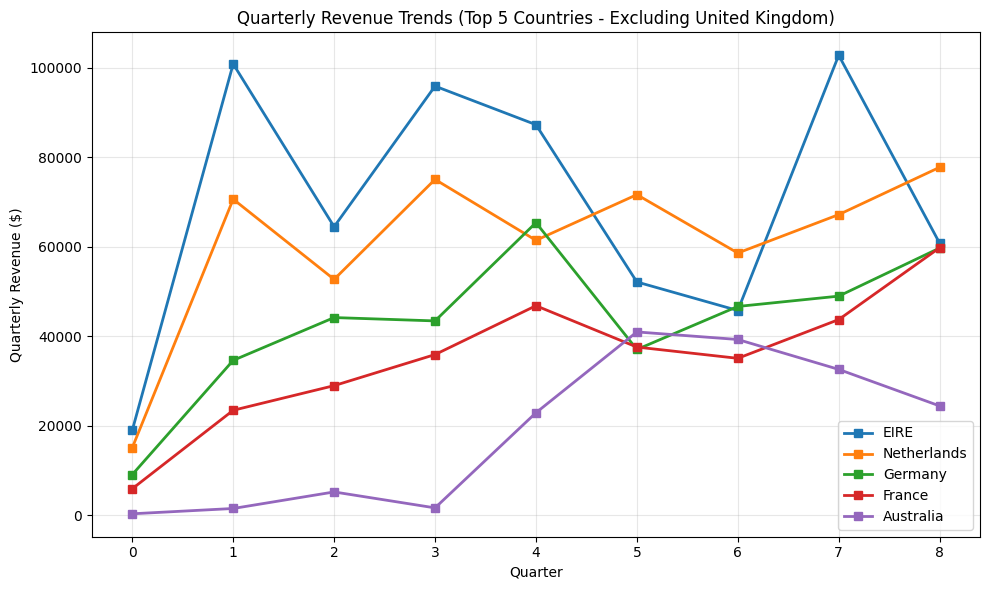

In [30]:
# Quarterly Revenue Trends (Top 5 Countries - Excluding UK) - Standalone
plt.figure(figsize=(10, 6))

# Get top 5 countries excluding UK
non_uk_data = df[df['country'] != 'United Kingdom']
top_5_non_uk = non_uk_data.groupby('country')['revenue'].sum().nlargest(5).index

quarterly_country = df[df['country'].isin(top_5_non_uk)].groupby(['quarter', 'country'])['revenue'].sum().reset_index()
for country in top_5_non_uk:
    country_q = quarterly_country[quarterly_country['country'] == country].sort_values('quarter')
    plt.plot(range(len(country_q)), country_q['revenue'].values, marker='s', label=country, linewidth=2)

plt.xlabel('Quarter')
plt.ylabel('Quarterly Revenue ($)')
plt.title('Quarterly Revenue Trends (Top 5 Countries - Excluding United Kingdom)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [32]:

print("\n EXPORT OPPORTUNITY ANALYSIS")
print("Countries with high transaction value but low frequency (expansion opportunity):")
expansion_opps = avg_transaction[
    (avg_transaction['avg_transaction'] > avg_transaction['avg_transaction'].median()) &
    (avg_transaction['num_transactions'] < avg_transaction['num_transactions'].median())
].sort_values('avg_transaction', ascending=False)
print(expansion_opps[['country', 'avg_transaction', 'num_transactions', 'total_revenue']].to_string(index=False))


 EXPORT OPPORTUNITY ANALYSIS
Countries with high transaction value but low frequency (expansion opportunity):
  country  avg_transaction  num_transactions  total_revenue
 Thailand        40.401842                76        3070.54
Singapore        39.633012               332       13158.16



REVENUE TRENDS INCLUDING UNITED KINGDOM

Top 5 countries (including UK): United Kingdom, EIRE, Netherlands, Germany, France


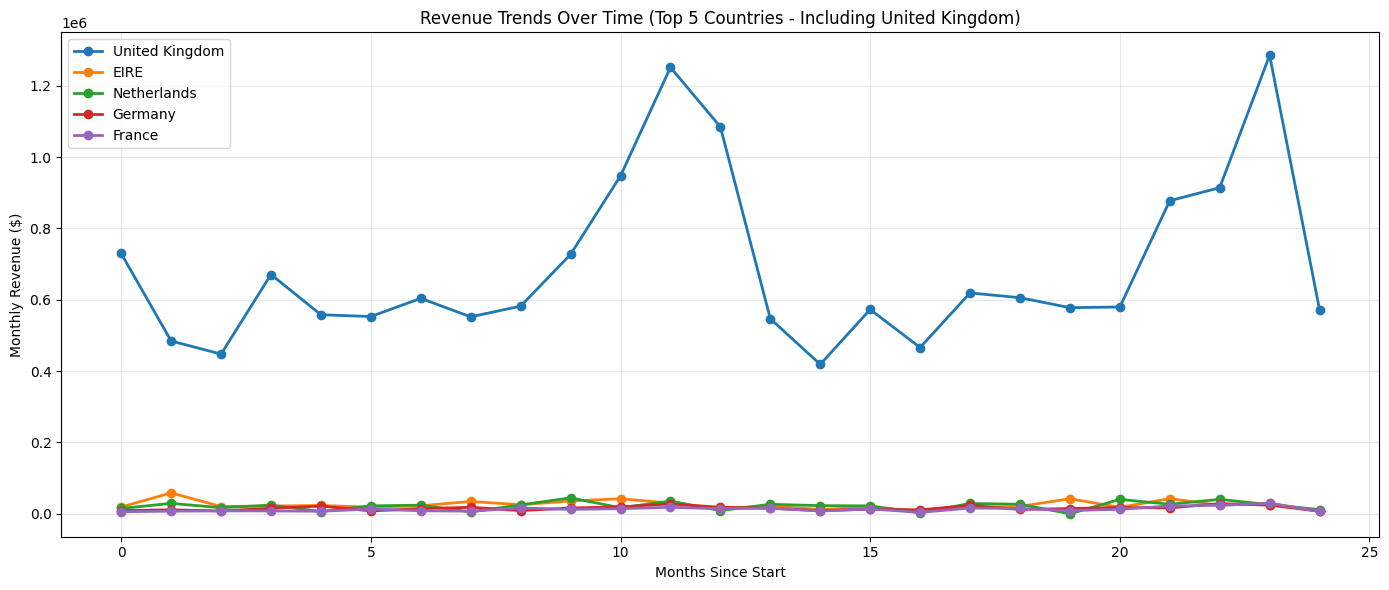


Revenue Summary (Including UK):
                Total Revenue  Avg Transaction  Num Transactions
country                                                         
United Kingdom    17233392.89        18.029372            955851
EIRE                628875.43        36.774190             17101
Netherlands         549952.66       110.365776              4983
Germany             388829.75        24.250327             16034
France              316948.80        23.564967             13450

REVENUE TRENDS EXCLUDING UNITED KINGDOM

Top 5 countries (excluding UK): EIRE, Netherlands, Germany, France, Australia


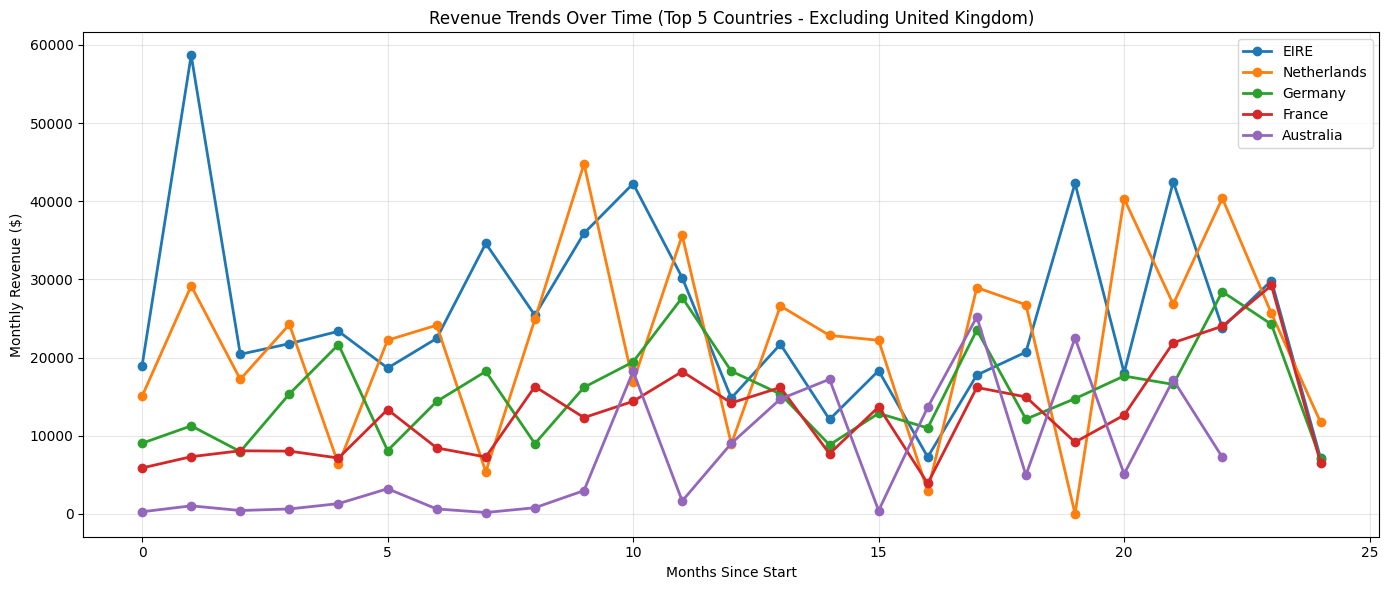


Revenue Summary (Excluding UK):
             Total Revenue  Avg Transaction  Num Transactions
country                                                      
EIRE             628875.43        36.774190             17101
Netherlands      549952.66       110.365776              4983
Germany          388829.75        24.250327             16034
France           316948.80        23.564967             13450
Australia        168484.66        93.291617              1806


In [33]:
# ADDITIONAL VISUALIZATIONS: Revenue Trends With and Without UK

# 1. Revenue Trends INCLUDING UK (Top 5 Countries)
print("\n" + "="*70)
print("REVENUE TRENDS INCLUDING UNITED KINGDOM")
print("="*70)

top_5_with_uk = df.groupby('country')['revenue'].sum().nlargest(5).index
print(f"\nTop 5 countries (including UK): {', '.join(top_5_with_uk)}")

monthly_with_uk = df[df['country'].isin(top_5_with_uk)].groupby(['year_month', 'country'])['revenue'].sum().reset_index()

plt.figure(figsize=(14, 6))
for country in top_5_with_uk:
    country_ts = monthly_with_uk[monthly_with_uk['country'] == country]
    plt.plot(range(len(country_ts)), country_ts['revenue'].values, marker='o', label=country, linewidth=2)

plt.xlabel('Months Since Start')
plt.ylabel('Monthly Revenue ($)')
plt.title('Revenue Trends Over Time (Top 5 Countries - Including United Kingdom)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics including UK
print("\nRevenue Summary (Including UK):")
with_uk_summary = df[df['country'].isin(top_5_with_uk)].groupby('country')['revenue'].agg(['sum', 'mean', 'count'])
with_uk_summary.columns = ['Total Revenue', 'Avg Transaction', 'Num Transactions']
with_uk_summary = with_uk_summary.sort_values('Total Revenue', ascending=False)
print(with_uk_summary)

# 2. Revenue Trends EXCLUDING UK (Top 5 Countries)
print("\n" + "="*70)
print("REVENUE TRENDS EXCLUDING UNITED KINGDOM")
print("="*70)

# Get top countries excluding UK
non_uk_data = df[df['country'] != 'United Kingdom']
top_5_non_uk = non_uk_data.groupby('country')['revenue'].sum().nlargest(5).index

print(f"\nTop 5 countries (excluding UK): {', '.join(top_5_non_uk)}")

# Prepare monthly data for non-UK countries
monthly_non_uk = non_uk_data[non_uk_data['country'].isin(top_5_non_uk)].groupby(['year_month', 'country'])['revenue'].sum().reset_index()

# Create the plot
plt.figure(figsize=(14, 6))
for country in top_5_non_uk:
    country_ts = monthly_non_uk[monthly_non_uk['country'] == country]
    plt.plot(range(len(country_ts)), country_ts['revenue'].values, marker='o', label=country, linewidth=2)

plt.xlabel('Months Since Start')
plt.ylabel('Monthly Revenue ($)')
plt.title('Revenue Trends Over Time (Top 5 Countries - Excluding United Kingdom)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics for non-UK top 5
print("\nRevenue Summary (Excluding UK):")
non_uk_summary = non_uk_data[non_uk_data['country'].isin(top_5_non_uk)].groupby('country')['revenue'].agg(['sum', 'mean', 'count'])
non_uk_summary.columns = ['Total Revenue', 'Avg Transaction', 'Num Transactions']
non_uk_summary = non_uk_summary.sort_values('Total Revenue', ascending=False)
print(non_uk_summary)


REVENUE TRENDS EXCLUDING UNITED KINGDOM

Top 5 countries (excluding UK): EIRE, Netherlands, Germany, France, Australia


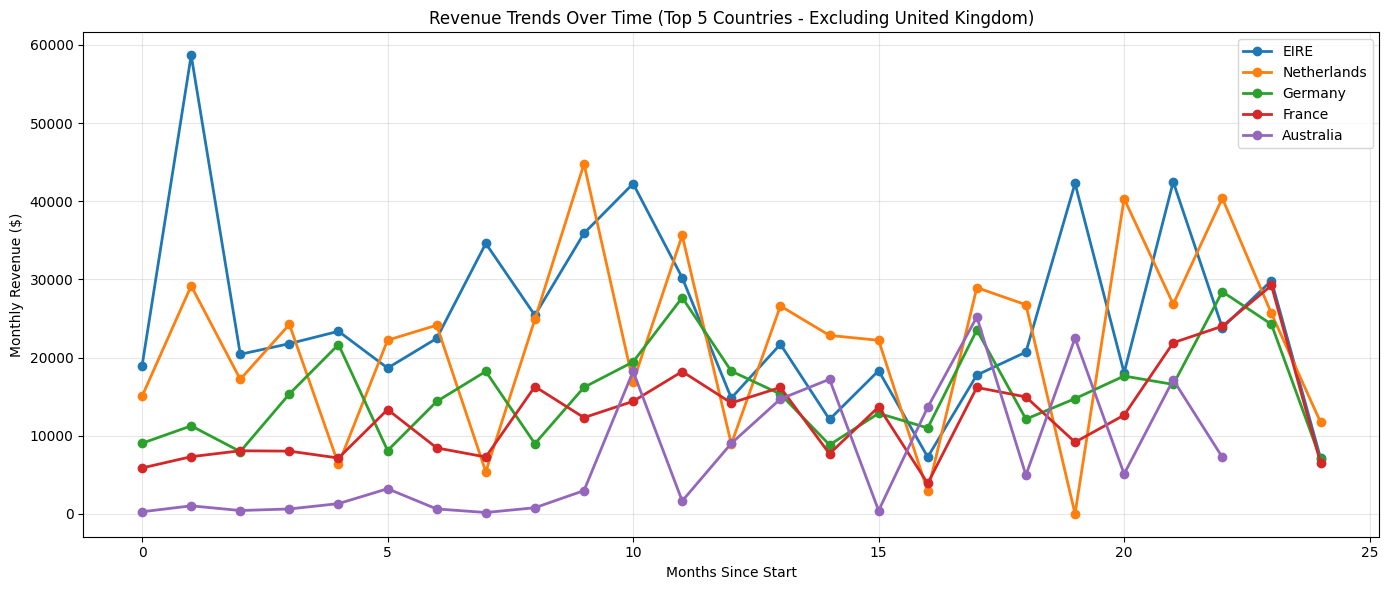


Revenue Summary (Excluding UK):
             Total Revenue  Avg Transaction  Num Transactions
country                                                      
EIRE             628875.43        36.774190             17101
Netherlands      549952.66       110.365776              4983
Germany          388829.75        24.250327             16034
France           316948.80        23.564967             13450
Australia        168484.66        93.291617              1806


In [34]:
# ADDITIONAL VISUALIZATION: Revenue Trends Excluding UK
print("\n" + "="*70)
print("REVENUE TRENDS EXCLUDING UNITED KINGDOM")
print("="*70)

# Get top countries excluding UK
non_uk_data = df[df['country'] != 'United Kingdom']
top_5_non_uk = non_uk_data.groupby('country')['revenue'].sum().nlargest(5).index

print(f"\nTop 5 countries (excluding UK): {', '.join(top_5_non_uk)}")

# Prepare monthly data for non-UK countries
monthly_non_uk = non_uk_data[non_uk_data['country'].isin(top_5_non_uk)].groupby(['year_month', 'country'])['revenue'].sum().reset_index()

# Create the plot
plt.figure(figsize=(14, 6))
for country in top_5_non_uk:
    country_ts = monthly_non_uk[monthly_non_uk['country'] == country]
    plt.plot(range(len(country_ts)), country_ts['revenue'].values, marker='o', label=country, linewidth=2)

plt.xlabel('Months Since Start')
plt.ylabel('Monthly Revenue ($)')
plt.title('Revenue Trends Over Time (Top 5 Countries - Excluding United Kingdom)')
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print summary statistics for non-UK top 5
print("\nRevenue Summary (Excluding UK):")
non_uk_summary = non_uk_data[non_uk_data['country'].isin(top_5_non_uk)].groupby('country')['revenue'].agg(['sum', 'mean', 'count'])
non_uk_summary.columns = ['Total Revenue', 'Avg Transaction', 'Num Transactions']
non_uk_summary = non_uk_summary.sort_values('Total Revenue', ascending=False)
print(non_uk_summary)

_Revenue Summary Analysis (Excluding United Kingdom)_
(Excludes UK to get a chart that is actually readable)

This analysis compares the top 5 non-UK markets by total revenue, average transaction value, and transaction volume. It highlights two strategies: high-volume, low-value (EIRE, Germany) versus high-value, lower-volume (Netherlands, Australia). The data shows a trade-off between transaction frequency and average transaction value across these markets.


----------------------------------------------------------------------------------------------

_Revenue Summary Analysis (Excluding United Kingdom)_
(Excludes UK to get a chart that is actually readable)

This analysis reveals distinct market characteristics among the top 5 non-UK markets:

**High-Volume, Low-Value Markets:**
- **EIRE** leads in total revenue ($628,875) through high transaction volume (17,101 transactions) despite a low average transaction value ($36.77), indicating a volume-driven strategy.
- **Germany** follows a similar pattern with $388,830 total revenue from 16,034 transactions at $24.25 per transaction.

**High-Value, Lower-Volume Markets:**
- **Netherlands** ranks second in total revenue ($549,953) with the highest average transaction value ($110.37) but fewer transactions (4,983), suggesting a premium customer base.
- **Australia** shows the second-highest average transaction value ($93.29) but the lowest transaction count (1,806), representing a potential growth opportunity with high-value customers.

**Balanced Market:**
- **France** shows moderate performance across all metrics ($316,949 total, $23.56 average, 13,450 transactions).

The data indicates a clear trade-off between transaction volume and average transaction value, with EIRE and Germany focusing on volume while Netherlands and Australia target higher-value customers.
```

## THE END :)